In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import warnings 
warnings.simplefilter(action='ignore')
import itertools
import numpy as np
import datetime as datetime 
import datetime as timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pylab import rcParams
from pandas.plotting import autocorrelation_plot

In [101]:
# Standardgröße für alle Plots festlegen
plt.rcParams['figure.figsize'] = (10, 5)

# Sensordaten Temperatur einlesen 

In [102]:
def parse_date(x):
    try:
        return pd.to_datetime(x, format='%m/%d/%Y %H:%M:%S')
    except ValueError:
        return pd.to_datetime(x, format='%d/%m/%Y %H:%M:%S')

#Sensordaten Temperatur einlesen 
temperature_data = pd.read_csv(
    'Sensor_Temp_23-04.csv',
    sep='|',
    header=0,
    parse_dates=['Date'],
    date_parser=parse_date
)

temperature_data.rename(columns={'Date': 'Datum', 'Value': 'Innenraum Temperatur'}, inplace=True)

temp_index = temperature_data.set_index('Datum')

print(temp_index.head(10))

                     Innenraum Temperatur
Datum                                    
2024-03-25 00:10:34                  12.2
2024-03-25 00:25:34                  12.2
2024-03-25 00:40:34                  12.1
2024-03-25 00:55:34                  12.1
2024-03-25 01:10:34                  12.1
2024-03-25 01:25:34                  12.0
2024-03-25 01:40:34                  12.0
2024-03-25 01:55:34                  12.0
2024-03-25 02:10:34                  11.9
2024-03-25 02:25:34                  11.9


# Täglicher Mittelwert bilden 

In [103]:
temp_index.index = pd.to_datetime(temp_index.index)

daily_avg = temp_index.resample('D').mean()
daily_avg = daily_avg
daily_avg.head(24)


print(daily_avg.head(10))

            Innenraum Temperatur
Datum                           
2024-03-25             12.448958
2024-03-26             12.463542
2024-03-27             13.917978
2024-03-28             14.976042
2024-03-29             14.493750
2024-03-30             15.451042
2024-03-31             17.179167
2024-04-01             17.075789
2024-04-02             16.333333
2024-04-03             15.793750


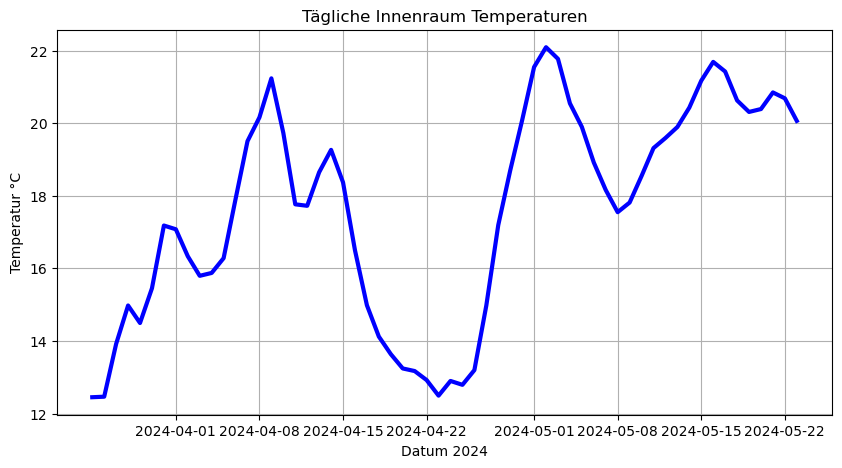

In [104]:
plt.plot(daily_avg['Innenraum Temperatur'], linewidth=3,c='blue')
plt.title("Tägliche Innenraum Temperaturen")
plt.xlabel("Datum 2024")
plt.ylabel("Temperatur °C")
plt.grid(True)
plt.show()


# Außentemperaturen historisch einbinden 

In [105]:
outdoor_data = pd.read_csv(
    'Temp_24.csv',
    sep=',',
    header=0,
    parse_dates=['Datum'],
    date_parser=lambda x: pd.to_datetime(x, format='%Y-%m-%d'),
    index_col='Datum'
)

outdoor_data.rename(columns={'Temp': 'Außentemperatur'}, inplace=True)


print(outdoor_data.head(10))

            Außentemperatur
Datum                      
2024-03-25              5.1
2024-03-26              8.1
2024-03-27             13.0
2024-03-28              9.9
2024-03-29             11.2
2024-03-30             17.0
2024-03-31             15.4
2024-04-01             13.8
2024-04-02             10.7
2024-04-03             11.0


In [106]:
# Daten auf gleiche Frequenz bringen (falls notwendig)
outdoor_data_daily = outdoor_data.resample('D').mean()

# Daten zusammenführen
data_sum = daily_avg.join(outdoor_data_daily, how='inner')

# Den Index zurück in eine Spalte konvertieren und dann als Index setzen
data_sum.reset_index(inplace=True)
data_sum.set_index('Datum', inplace=True)

# Überprüfen, ob Daten erfolgreich zusammengeführt wurden
print(data_sum.head(10))

            Innenraum Temperatur  Außentemperatur
Datum                                            
2024-03-25             12.448958              5.1
2024-03-26             12.463542              8.1
2024-03-27             13.917978             13.0
2024-03-28             14.976042              9.9
2024-03-29             14.493750             11.2
2024-03-30             15.451042             17.0
2024-03-31             17.179167             15.4
2024-04-01             17.075789             13.8
2024-04-02             16.333333             10.7
2024-04-03             15.793750             11.0


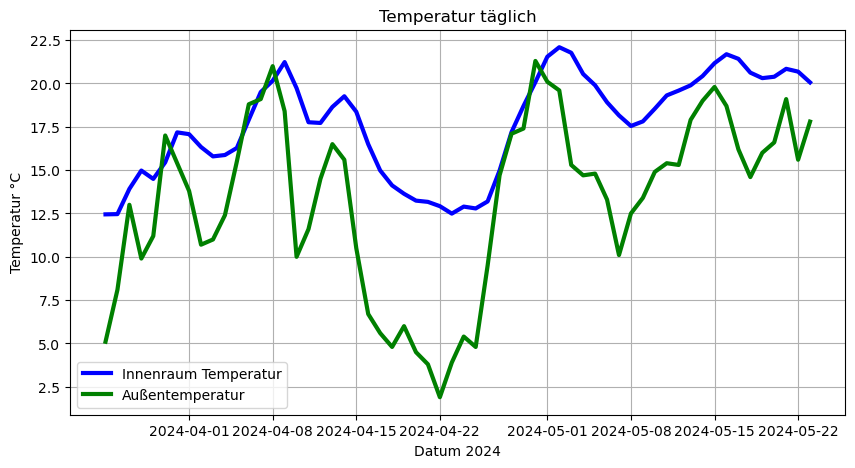

In [107]:
plt.plot(daily_avg.index, daily_avg['Innenraum Temperatur'], linewidth=3,c='blue', label='Innenraum Temperatur')
plt.plot(outdoor_data.index, outdoor_data['Außentemperatur'], linewidth=3,c='green', label='Außentemperatur')

plt.title("Temperatur täglich")
plt.xlabel("Datum 2024")
plt.ylabel("Temperatur °C")

plt.grid(True)
plt.legend()
plt.show()

# AR(p) und MA(q) 

## ACF und PACF 

In [108]:
#plot_acf(daily_avg)
#plot_pacf(daily_avg)
#plt.show()

#Lag 0 wird nicht berücksichtigt 
# AR
# ACF ist geometric decay/sine function decay - kein Wert für p ablesbar
# PACF p=2
# --> AR(2) 
# MA
# ACF GD
# PACF kein GD, somit keine MA 
# --> MA(0) 

## Stationarität Dickey Fuller Test ADF 

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(daily_avg)

In [109]:
# Stationarität ist nicht vorhanden, daher muss differenziert werden 

# Differenzierung

daily_avg = daily_avg - daily_avg.shift(1)
daily_avg = daily_avg.dropna()

plt.plot(daily_avg)
plt.axhline(0, color='red', linestyle='--', alpha=0.2)


In [110]:
# erneute Überprüfung der Stationarität mit ADF

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.axhline(0, color='red', linestyle='--', alpha=0.2)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.show(block=False)


    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(daily_avg)

plot_acf(daily_avg)
plot_pacf(daily_avg)
plt.show()

In [112]:
#Lag 0 wird nicht berücksichtigt 
# AR
# ACF ist geometric decay/sine function decay - kein Wert für p ablesbar
# PACF p=2
# --> AR(2) 
# MA
# ACF GD
# PACF kein GD, somit keine MA 
# --> MA(0) 
# einmal differenziert 
# --> I(1) 
# -----> ARIMA (p,i,q) = ARIMA (2, 1, 0) 

# Training Daten 

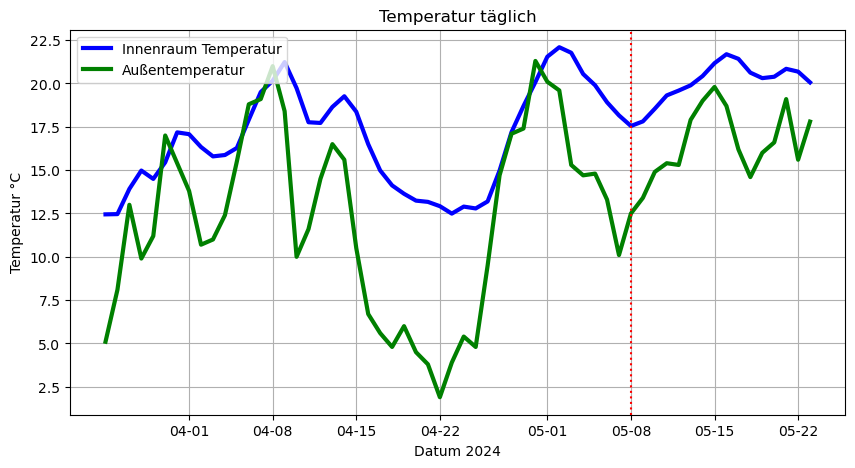

In [113]:
MAX_TRAINING_DATE = data_sum.tail(16).index[0]

plt.plot(daily_avg.index, daily_avg['Innenraum Temperatur'], linewidth=3,c='blue', label='Innenraum Temperatur')
plt.plot(outdoor_data.index, outdoor_data['Außentemperatur'], linewidth=3,c='green', label='Außentemperatur')

plt.title("Temperatur täglich")
plt.xlabel("Datum 2024")
plt.ylabel("Temperatur °C")

plt.axvline(MAX_TRAINING_DATE, color='red', linestyle='dotted')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.grid(True)
plt.legend(loc='upper left')
plt.show()

train = data_sum.loc[data_sum.index < MAX_TRAINING_DATE, :]
test = data_sum.loc[data_sum.index >= MAX_TRAINING_DATE, :]

# Build a model

In [116]:
model = SARIMAX(
    endog = data_sum['Innenraum Temperatur'],
    exog = data_sum['Außentemperatur'], 
    order = (1,1,1),
    trend = 'n',
    seasonal_order =(0,1,1,7)
)

fitted_model=model.fit()
print(fitted_model.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20149D+00    |proj g|=  8.88639D-01

At iterate    5    f=  1.02854D+00    |proj g|=  1.81388D-01

At iterate   10    f=  1.00798D+00    |proj g|=  1.23134D-02

At iterate   15    f=  1.00500D+00    |proj g|=  3.84142D-02

At iterate   20    f=  1.00457D+00    |proj g|=  4.60822D-03

At iterate   25    f=  1.00451D+00    |proj g|=  2.86411D-03

At iterate   30    f=  1.00450D+00    |proj g|=  4.44775D-04

At iterate   35    f=  1.00450D+00    |proj g|=  2.14068D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

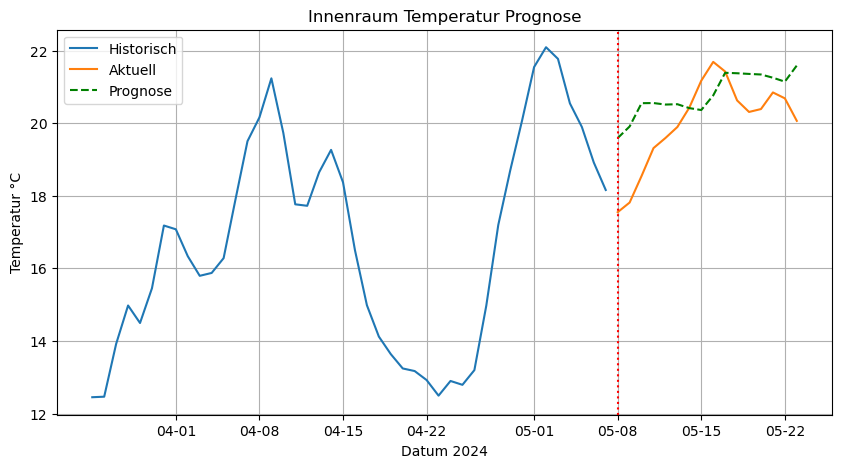

In [117]:
forecast = fitted_model.get_forecast(steps=test.shape[0], exog=test['Außentemperatur'])
forecast_mean = forecast.predicted_mean

# Plot erstellen
plt.plot(train.index, train['Innenraum Temperatur'], label='Historisch')
plt.plot(test.index, test['Innenraum Temperatur'], label='Aktuell')
plt.plot(test.index, forecast_mean, label='Prognose', linestyle='--', color='green')

plt.axvline(MAX_TRAINING_DATE, color='red', linestyle='dotted')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))


plt.title("Innenraum Temperatur Prognose")
plt.xlabel("Datum 2024")
plt.ylabel("Temperatur °C")
plt.legend()
plt.grid(True)
plt.show()

In [97]:
# Parameterbereiche festlegen
p_range = range(0, 3)  # Beispielbereich für p
d_range = range(0, 2)  # Beispielbereich für d
q_range = range(0, 3)  # Beispielbereich für q
P_range = range(0, 3)  # Beispielbereich für P
D_range = range(0, 2)  # Beispielbereich für D
Q_range = range(0, 3)  # Beispielbereich für Q
s = 7  # Saisonalitätsperiode

# Alle Kombinationen der Parameterwerte erstellen
param_grid = list(itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range))

best_aic = np.inf
best_params = None

# Grid Search durchführen
for params in param_grid:
    try:
        model = SARIMAX(endog=train['Innenraum Temperatur'], exog=train['Außentemperatur'], order=params[:3],
                        seasonal_order=(params[3], params[4], params[5], s))
        fitted_model = model.fit()
        if fitted_model.aic < best_aic:
            best_aic = fitted_model.aic
            best_params = params
    except:
        continue

print("Beste SARIMA-Parameter:", best_params)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.41462D+00    |proj g|=  2.99775D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4     15      1     0     0   2.290D-06   3.011D+00
  F =   3.0111630568511454     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.86077D+00    |proj g|=  5.11632D-02

At iterate   10    f=  1.84988D+00    |proj g|=  2.84518D-02

At iterate   15    f=  1.84890D+00    |proj g|=  2.56034D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   1.628D-05   1.849D+00
  F =   1.8488997092947863     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00637D+00    |proj g|=  2.04227D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.15831D+00    |proj g|=  4.36264D-01

At iterate   10    f=  3.00641D+00    |proj g|=  2.56285D-02

At iterate   15    f=  2.99610D+00    |proj g|=  5.99236D-03

At iterate   20    f=  2.99314D+00    |proj g|=  1.17439D-02

At iterate   25    f=  2.99295D+00    |proj g|=  1.02879D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   1.041D-05   2.993D+00
  F =   2.9929451851100684     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92993D+00    |proj g|=  2.84326D-01

At iterate    5    f=  1.83609D+00    |proj g|=  2.18534D-02

At iterate   10    f=  1.83524D+00    |proj g|=  1.29320D-02

At iterate   15    f=  1.83393D+00    |proj g|=  2.57127D-03

At iterate   20    f=  1.83392D+00    |proj g|=  4.77565D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     22      1     0     0   4.776D-06   1.834D+00
  F =   1.8339212812681511     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.50377D+00    |proj g|=  3.59698D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     25      1     0     0   5.318D-06   2.504D+00
  F =   2.5037669368401536     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03957D+00    |proj g|=  2.51045D-01

At iterate    5    f=  2.98579D+00    |proj g|=  2.60528D-01

At iterate   10    f=  2.57310D+00    |proj g|=  3.57796D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76634D+00    |proj g|=  1.84928D+00

At iterate    5    f=  3.11223D+00    |proj g|=  1.90843D-01

At iterate   10    f=  2.87236D+00    |proj g|=  1.82522D-01

At iterate   15    f=  2.54434D+00    |proj g|=  1.56230D-01

At iterate   20    f=  2.46044D+00    |proj g|=  7.61127D-02

At iterate   25    f=  2.45676D+00    |proj g|=  3.53474D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     34      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.79792D+00    |proj g|=  7.96410D-02

At iterate   10    f=  1.75595D+00    |proj g|=  2.38471D-02

At iterate   15    f=  1.75298D+00    |proj g|=  1.22130D-02

At iterate   20    f=  1.75283D+00    |proj g|=  2.81958D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     25      1     0     0   2.140D-05   1.753D+00
  F =   1.7528339546604641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.69676D+00    |proj g|=  1.93401D-02

At iterate   15    f=  2.65075D+00    |proj g|=  5.57658D-02

At iterate   20    f=  2.63601D+00    |proj g|=  3.41051D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   7.989D-06   2.636D+00
  F =   2.6360051461254912     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74901D+00    |proj g|=  3.02058D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.55200D+00    |proj g|=  7.47402D-02

At iterate   10    f=  1.55103D+00    |proj g|=  5.61356D-02

At iterate   15    f=  1.54843D+00    |proj g|=  1.73099D-03

At iterate   20    f=  1.54837D+00    |proj g|=  3.00371D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   3.004D-06   1.548D+00
  F =   1.5483742665645404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  2.08017D+00    |proj g|=  4.51522D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     64      1     0     0   1.566D-05   2.080D+00
  F =   2.0801572883195862     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.15364D+00    |proj g|=  5.26512D-01

At iterate    5    f=  2.78751D+00    |proj g|=  1.39588D-01

At iterate   10    f=  2.69901D+00    |proj g|=  2.18588D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.50981D+00    |proj g|=  1.91540D-02

At iterate   10    f=  1.50608D+00    |proj g|=  4.80058D-03

At iterate   15    f=  1.50542D+00    |proj g|=  1.37958D-03

At iterate   20    f=  1.50479D+00    |proj g|=  4.63841D-02

At iterate   25    f=  1.50436D+00    |proj g|=  1.55488D-03

At iterate   30    f=  1.50417D+00    |proj g|=  2.65024D-03

At iterate   35    f=  1.50413D+00    |proj g|=  2.48274D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     47      1     0     0   1.824D-05   1.504D+00
  F =   1.5041300660373513     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  2.12417D+00    |proj g|=  2.57718D-03

At iterate   35    f=  2.12416D+00    |proj g|=  1.16521D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     53      1     0     0   1.165D-05   2.124D+00
  F =   2.1241596643119682     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77366D+00    |proj g|=  4.80623D-01

At iterate    5    f=  2.58894D+00    |proj g|=  6.40063D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  2.08959D+00    |proj g|=  1.44788D-02

At iterate   25    f=  2.08868D+00    |proj g|=  4.45709D-03

At iterate   30    f=  2.08343D+00    |proj g|=  7.43054D-02

At iterate   35    f=  2.08165D+00    |proj g|=  5.28005D-02

At iterate   40    f=  2.07988D+00    |proj g|=  7.41572D-03

At iterate   45    f=  2.07986D+00    |proj g|=  2.14369D-04

At iterate   50    f=  2.07970D+00    |proj g|=  6.89384D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     78      1     0     0   6.894D-03   2.080D+00
  F =   2.0796958309795035     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   25    f=  1.42867D+00    |proj g|=  1.34253D-03

At iterate   30    f=  1.42865D+00    |proj g|=  8.87280D-04

At iterate   35    f=  1.42864D+00    |proj g|=  9.90228D-05

At iterate   40    f=  1.42864D+00    |proj g|=  4.76951D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     64      1     0     0   4.770D-05   1.429D+00
  F =   1.4286444040137578     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  1.42253D+00    |proj g|=  4.26482D-02

At iterate   25    f=  1.42197D+00    |proj g|=  6.55579D-03

At iterate   30    f=  1.42188D+00    |proj g|=  9.44020D-04

At iterate   35    f=  1.42186D+00    |proj g|=  6.88500D-04

At iterate   40    f=  1.42186D+00    |proj g|=  1.59994D-04

At iterate   45    f=  1.42186D+00    |proj g|=  7.01669D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     64      1     0     0   9.933D-06   1.422D+00
  F =   1.4218630519035744     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  1.42106D+00    |proj g|=  7.88581D-03

At iterate   20    f=  1.42035D+00    |proj g|=  2.96057D-02

At iterate   25    f=  1.41930D+00    |proj g|=  3.81744D-03

At iterate   30    f=  1.41896D+00    |proj g|=  5.37538D-04

At iterate   35    f=  1.41893D+00    |proj g|=  2.58322D-03

At iterate   40    f=  1.41893D+00    |proj g|=  3.68402D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   45    f=  1.41892D+00    |proj g|=  2.08110D-04

At iterate   50    f=  1.41892D+00    |proj g|=  8.84808D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     77      2     0     0   8.848D-05   1.419D+00
  F =   1.4189234411801073     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66018D+00    |proj g|=  4.91375D-01

At iterate    5    f=  2.55134D+00    |proj g|=  6.04598D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  2.18535D+00    |proj g|=  5.87920D-03

At iterate   25    f=  2.18407D+00    |proj g|=  3.83034D-03

At iterate   30    f=  2.18392D+00    |proj g|=  7.24547D-04

At iterate   35    f=  2.18391D+00    |proj g|=  3.16897D-04

At iterate   40    f=  2.18390D+00    |proj g|=  3.72275D-04

At iterate   45    f=  2.18390D+00    |proj g|=  2.26672D-04

At iterate   50    f=  2.18390D+00    |proj g|=  4.73290D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   4.733D-05   2.184D+00
  F =   2.1839033359195992     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.44624D+00    |proj g|=  6.17014D-02

At iterate   10    f=  1.44109D+00    |proj g|=  3.23646D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   2.278D-05   1.441D+00
  F =   1.4410799142536417     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67558D+00    |proj g|=  4.63638D-01

At iterate    5    f=  1.43318D+00    |proj g|=  3.90017D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  1.34631D+00    |proj g|=  5.52185D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     56      1     0     0   5.522D-04   1.346D+00
  F =   1.3463140779183806     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66588D+00    |proj g|=  5.62694D-01

At iterate    5    f=  2.24299D+00    |proj g|=  5.51679D-01

At iterate   10    f=  1.91205D+00    |proj g|=  1.03696D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  2.07431D+00    |proj g|=  3.68990D-01

At iterate   25    f=  2.04310D+00    |proj g|=  1.09373D-02

At iterate   30    f=  2.04000D+00    |proj g|=  7.69948D-02

At iterate   35    f=  2.03716D+00    |proj g|=  5.75759D-03

At iterate   40    f=  2.03598D+00    |proj g|=  2.73987D-02

At iterate   45    f=  2.03556D+00    |proj g|=  7.70980D-03

At iterate   50    f=  2.03545D+00    |proj g|=  9.51842D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   9.518D-04   2.035D+00
  F =   2.0354542511455205     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.66504D+00    |proj g|=  7.67042D-01

At iterate    5    f=  1.44597D+00    |proj g|=  3.34424D-02

At iterate   10    f=  1.44041D+00    |proj g|=  3.54630D-03

At iterate   15    f=  1.44036D+00    |proj g|=  3.60412D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   3.604D-06   1.440D+00
  F =   1.4403613884270277     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  1.35220D+00    |proj g|=  9.23373D-02

At iterate   10    f=  1.33897D+00    |proj g|=  5.22679D-03

At iterate   15    f=  1.33804D+00    |proj g|=  5.59863D-03

At iterate   20    f=  1.33796D+00    |proj g|=  4.49264D-03

At iterate   25    f=  1.33795D+00    |proj g|=  1.44247D-03

At iterate   30    f=  1.33795D+00    |proj g|=  2.21437D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     35      1     0     0   3.624D-05   1.338D+00
  F =   1.3379450781492268     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  1.88307D+00    |proj g|=  4.29907D-02

At iterate   25    f=  1.87097D+00    |proj g|=  4.47127D-02

At iterate   30    f=  1.85868D+00    |proj g|=  2.41209D-02

At iterate   35    f=  1.85685D+00    |proj g|=  3.11199D-02

At iterate   40    f=  1.85642D+00    |proj g|=  3.38868D-03

At iterate   45    f=  1.85638D+00    |proj g|=  1.26783D-03

At iterate   50    f=  1.85637D+00    |proj g|=  7.25771D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61      1     0     0   7.258D-04   1.856D+00
  F =   1.8563730500732367     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  1.94774D+00    |proj g|=  3.13719D-01

At iterate   15    f=  1.85324D+00    |proj g|=  3.93763D-02

At iterate   20    f=  1.83408D+00    |proj g|=  5.57864D-02

At iterate   25    f=  1.81604D+00    |proj g|=  4.25929D-02

At iterate   30    f=  1.81441D+00    |proj g|=  3.29357D-02

At iterate   35    f=  1.81382D+00    |proj g|=  5.60806D-03

At iterate   40    f=  1.81379D+00    |proj g|=  6.62245D-04

At iterate   45    f=  1.81377D+00    |proj g|=  5.14992D-03

At iterate   50    f=  1.81375D+00    |proj g|=  8.20869D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61   

 This problem is unconstrained.



At iterate    5    f=  2.49576D+00    |proj g|=  2.30677D-01

At iterate   10    f=  1.96587D+00    |proj g|=  3.70320D-01

At iterate   15    f=  1.91205D+00    |proj g|=  9.65082D-02

At iterate   20    f=  1.88319D+00    |proj g|=  9.17107D-02

At iterate   25    f=  1.87075D+00    |proj g|=  8.71979D-02

At iterate   30    f=  1.84540D+00    |proj g|=  2.82630D-02

At iterate   35    f=  1.80848D+00    |proj g|=  6.07654D-01

At iterate   40    f=  1.75558D+00    |proj g|=  5.74412D-02

At iterate   45    f=  1.75526D+00    |proj g|=  1.85865D-03

At iterate   50    f=  1.75449D+00    |proj g|=  3.33983D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.27458D+00    |proj g|=  8.58999D-02

At iterate   15    f=  1.27139D+00    |proj g|=  9.67044D-03

At iterate   20    f=  1.27135D+00    |proj g|=  2.72477D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     27      1     0     0   2.725D-05   1.271D+00
  F =   1.2713538315778459     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65642D+00    |proj g|=  7.81383D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  1.24041D+00    |proj g|=  2.69861D-04

At iterate   40    f=  1.24041D+00    |proj g|=  2.86504D-03

At iterate   45    f=  1.24034D+00    |proj g|=  5.86992D-03

At iterate   50    f=  1.23995D+00    |proj g|=  1.89243D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     87      2     0     0   1.892D-02   1.240D+00
  F =   1.2399460760579393     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.29848D+00    |proj g|=  7.23264D-02

At iterate   10    f=  1.26382D+00    |proj g|=  1.79530D-01

At iterate   15    f=  1.24218D+00    |proj g|=  1.94148D-02

At iterate   20    f=  1.23853D+00    |proj g|=  7.35751D-03

At iterate   25    f=  1.23794D+00    |proj g|=  2.34301D-02

At iterate   30    f=  1.23753D+00    |proj g|=  1.15158D-02

At iterate   35    f=  1.23751D+00    |proj g|=  7.57603D-04

At iterate   40    f=  1.23751D+00    |proj g|=  1.04948D-03

At iterate   45    f=  1.23750D+00    |proj g|=  1.23753D-03

At iterate   50    f=  1.23750D+00    |proj g|=  1.49515D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.34556D+00    |proj g|=  9.96880D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     20      1     0     0   3.476D-05   1.346D+00
  F =   1.3455525664956178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30090D+00    |proj g|=  1.90976D-01

At iterate    5    f=  1.26190D+00    |proj g|=  4.45158D-02

At iterate   10    f=  1.24648D+00    |proj g|=  6.50534D-03

At iter

 This problem is unconstrained.



At iterate   15    f=  1.24529D+00    |proj g|=  8.57614D-03

At iterate   20    f=  1.24516D+00    |proj g|=  1.20627D-03

At iterate   25    f=  1.24513D+00    |proj g|=  1.40366D-03

At iterate   30    f=  1.24513D+00    |proj g|=  9.26451D-04
  ys=-9.217E-09  -gs= 1.968E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     56      1     1     0   7.700D-05   1.245D+00
  F =   1.2451310858753286     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.30742D+00    |proj g|=  1.29106D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     31      1     0     0   1.291D-05   1.307D+00
  F =   1.3074179556837822     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31505D+00    |proj g|=  1.95118D-01

At iterate    5    f=  1.31099D+00    |proj g|=  3.30737D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  1.24539D+00    |proj g|=  5.26404D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     63      2     0     0   2.133D-06   1.245D+00
  F =   1.2453918766810435     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34622D+00    |proj g|=  2.05370D-01

At iterate    5    f=  1.24461D+00    |proj g|=  2.92003D-02

At iterate   10    f=  1.23748D+00    |proj g|=  2.31806D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.23645D+00    |proj g|=  1.67019D-03

At iterate   30    f=  1.23643D+00    |proj g|=  1.65801D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     45      1     0     0   1.593D-04   1.236D+00
  F =   1.2364343861095379     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31316D+00    |proj g|=  6.63085D-02

At iterate    5    f=  1.31058D+00    |proj g|=  3.04270D-03

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.31135D+00    |proj g|=  1.88630D-02

At iterate   15    f=  1.30722D+00    |proj g|=  5.69242D-03

At iterate   20    f=  1.30710D+00    |proj g|=  8.66478D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   8.665D-06   1.307D+00
  F =   1.3070980138544481     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35523D+00    |proj g|=  1.89997D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.23212D+00    |proj g|=  1.15654D-02

At iterate   20    f=  1.23188D+00    |proj g|=  1.40539D-03

At iterate   25    f=  1.23185D+00    |proj g|=  4.03826D-03

At iterate   30    f=  1.23184D+00    |proj g|=  1.68426D-03

At iterate   35    f=  1.23184D+00    |proj g|=  4.39259D-04

At iterate   40    f=  1.23184D+00    |proj g|=  1.20636D-03

At iterate   45    f=  1.23184D+00    |proj g|=  8.16661D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     65      1     0     0   8.167D-05   1.232D+00
  F =   1.2318397092579099     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  1.23362D+00    |proj g|=  8.06369D-03

At iterate   15    f=  1.23315D+00    |proj g|=  6.47686D-04

At iterate   20    f=  1.23308D+00    |proj g|=  4.24077D-03

At iterate   25    f=  1.23163D+00    |proj g|=  1.25998D-02

At iterate   30    f=  1.23121D+00    |proj g|=  3.88877D-03

At iterate   35    f=  1.23116D+00    |proj g|=  8.49676D-04

At iterate   40    f=  1.23116D+00    |proj g|=  1.15493D-03

At iterate   45    f=  1.23114D+00    |proj g|=  2.28782D-03

At iterate   50    f=  1.23113D+00    |proj g|=  2.11129D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     57      1     0     0   1.234D-03   1.069D+00
  F =   1.0689907368573097     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21054D+00    |proj g|=  9.64699D-01

At iterate    5    f=  1.09115D+00    |proj g|=  9.66142D-02

At iterate   10    f=  1.07154D+00    |proj g|=  1.17519D-01

At iterate   15    f=  1.06214D+00    |proj g|=  1.09227D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     46      1     0     0   6.202D-04   1.039D+00
  F =   1.0388720166031857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24682D+00    |proj g|=  8.87515D-01

At iterate    5    f=  1.06045D+00    |proj g|=  1.96404D-01

At iterate   10    f=  1.03225D+00    |proj g|=  3.26541D-02

At iterate   15    f=  1.02739D+00    |proj g|=  6.75553D-03

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     42      1     0     0   7.461D-05   1.063D+00
  F =   1.0634254679514779     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26489D+00    |proj g|=  1.08567D+00

At iterate    5    f=  1.11065D+00    |proj g|=  7.64650D-02

At iterate   10    f=  1.06870D+00    |proj g|=  9.74328D-02

At iterate   15    f=  1.06304D+00    |proj g|=  6.88996D-03

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24217D+00    |proj g|=  1.08660D+00

At iterate    5    f=  1.12053D+00    |proj g|=  1.58740D-01

At iterate   10    f=  1.04157D+00    |proj g|=  6.63715D-02

At iterate   15    f=  1.02967D+00    |proj g|=  3.04037D-02

At iterate   20    f=  1.02861D+00    |proj g|=  1.12584D-02

At iterate   25    f=  1.02846D+00    |proj g|=  9.68607D-03

At iterate   30    f=  1.02846D+00    |proj g|=  1.24301D-02

At iterate   35    f=  1.02845D+00    |proj g|=  4.58960D-03

At iterate   40    f=  1.02845D+00    |proj g|=  4.35460D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.02773D+00    |proj g|=  4.59023D-02

At iterate   15    f=  1.02648D+00    |proj g|=  2.46917D-02

At iterate   20    f=  1.02567D+00    |proj g|=  7.24176D-03

At iterate   25    f=  1.02560D+00    |proj g|=  9.19968D-03

At iterate   30    f=  1.02558D+00    |proj g|=  3.07359D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     47      1     0     0   1.834D-03   1.026D+00
  F =   1.0255774306651102     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   35    f=  1.06220D+00    |proj g|=  6.26447D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     67      2     0     0   6.264D-05   1.062D+00
  F =   1.0621993676537209     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25613D+00    |proj g|=  9.89791D-01

At iterate    5    f=  1.11818D+00    |proj g|=  8.89950D-02

At iterate   10    f=  1.06764D+00    |proj g|=  1.42560D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f=  1.06053D+00    |proj g|=  1.08451D-03

At iterate   35    f=  1.06052D+00    |proj g|=  3.98522D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     44      1     0     0   8.855D-05   1.061D+00
  F =   1.0605217697040386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21768D+00    |proj g|=  9.09161D-01

At iterate    5    f=  1.10207D+00    |proj g|=  1.10237D-01

At iter

 This problem is unconstrained.



At iterate   25    f=  1.03565D+00    |proj g|=  1.59803D-02

At iterate   30    f=  1.03564D+00    |proj g|=  4.37113D-04

At iterate   35    f=  1.03564D+00    |proj g|=  1.05369D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     46      1     0     0   1.054D-04   1.036D+00
  F =   1.0356396976401945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22028D+00    |proj g|=  8.39150D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  1.04281D+00    |proj g|=  1.34331D-01

At iterate   15    f=  1.02870D+00    |proj g|=  7.08722D-02

At iterate   20    f=  1.02737D+00    |proj g|=  3.35605D-02

At iterate   25    f=  1.02709D+00    |proj g|=  7.53837D-03

At iterate   30    f=  1.02705D+00    |proj g|=  3.08192D-03

At iterate   35    f=  1.02705D+00    |proj g|=  5.08312D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     58      1     0     0   3.933D-04   1.027D+00
  F =   1.0270473100747994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  1.02941D+00    |proj g|=  2.14264D-02

At iterate   15    f=  1.02455D+00    |proj g|=  4.69320D-02

At iterate   20    f=  1.02372D+00    |proj g|=  2.60926D-03

At iterate   25    f=  1.02365D+00    |proj g|=  1.09850D-02

At iterate   30    f=  1.02349D+00    |proj g|=  2.34347D-03

At iterate   35    f=  1.02346D+00    |proj g|=  7.68259D-03

At iterate   40    f=  1.02346D+00    |proj g|=  2.48340D-04

At iterate   45    f=  1.02346D+00    |proj g|=  8.63365D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     79      1     0     0   5.733D-04   1.023D+00
  F =   1.02345711047

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.09358D+00    |proj g|=  2.20750D-01

At iterate   10    f=  1.06981D+00    |proj g|=  1.01222D-01

At iterate   15    f=  1.05644D+00    |proj g|=  2.62539D-02

At iterate   20    f=  1.05544D+00    |proj g|=  2.85721D-03

At iterate   25    f=  1.05530D+00    |proj g|=  8.00368D-03

At iterate   30    f=  1.05527D+00    |proj g|=  2.83589D-03

At iterate   35    f=  1.05527D+00    |proj g|=  1.73489D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     46      1     0     0   6.318D-05   1.055D+00
  F =   1.0552698529363200     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.14142D+00    |proj g|=  2.15198D-01

At iterate   10    f=  1.09315D+00    |proj g|=  1.29556D-01

At iterate   15    f=  1.08155D+00    |proj g|=  1.16824D-01

At iterate   20    f=  1.08031D+00    |proj g|=  5.89427D-03

At iterate   25    f=  1.08019D+00    |proj g|=  1.04189D-02

At iterate   30    f=  1.08019D+00    |proj g|=  6.02996D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     40      1     0     0   1.341D-05   1.080D+00
  F =   1.0801851477103384     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  1.02032D+00    |proj g|=  2.45530D-02

At iterate   20    f=  1.01947D+00    |proj g|=  2.65606D-02

At iterate   25    f=  1.01939D+00    |proj g|=  8.85102D-03

At iterate   30    f=  1.01938D+00    |proj g|=  7.05411D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     47      1     0     0   3.839D-04   1.019D+00
  F =   1.0193813692677876     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.10625D+00    |proj g|=  1.94999D-01

At iterate   10    f=  1.07321D+00    |proj g|=  4.09149D-02

At iterate   15    f=  1.05940D+00    |proj g|=  7.94133D-02

At iterate   20    f=  1.05662D+00    |proj g|=  1.69571D-02

At iterate   25    f=  1.05639D+00    |proj g|=  2.00989D-03

At iterate   30    f=  1.05622D+00    |proj g|=  2.10885D-02

At iterate   35    f=  1.05374D+00    |proj g|=  2.98728D-02

At iterate   40    f=  1.05368D+00    |proj g|=  3.08130D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     51      1     0     0   1.377D-04   1.054D+00
  F =   1.05367727273

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   25    f=  1.05419D+00    |proj g|=  5.69615D-03

At iterate   30    f=  1.05415D+00    |proj g|=  5.21463D-03

At iterate   35    f=  1.05415D+00    |proj g|=  7.16059D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     62      2     0     0   7.638D-05   1.054D+00
  F =   1.0541508291952129     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24769D+00    |proj g|=  1.15410D+00

At iter

 This problem is unconstrained.



At iterate   20    f=  1.02064D+00    |proj g|=  1.32538D-02

At iterate   25    f=  1.02035D+00    |proj g|=  8.21662D-03
  ys=-7.579E-06  -gs= 7.135E-06 BFGS update SKIPPED

At iterate   30    f=  1.02029D+00    |proj g|=  2.80578D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     53      1     1     0   2.857D-03   1.020D+00
  F =   1.0202929776531684     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

 This problem is unconstrained.



At iterate   10    f=  1.06300D+00    |proj g|=  2.15483D-01

At iterate   15    f=  1.05618D+00    |proj g|=  6.22803D-03

At iterate   20    f=  1.05549D+00    |proj g|=  6.90691D-03

At iterate   25    f=  1.05536D+00    |proj g|=  1.05199D-02

At iterate   30    f=  1.05533D+00    |proj g|=  3.21400D-03

At iterate   35    f=  1.05533D+00    |proj g|=  1.01649D-03

At iterate   40    f=  1.05533D+00    |proj g|=  1.29295D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     80      2     0     0   1.293D-04   1.055D+00
  F =   1.0553275706354046     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28048D+00    |proj g|=  1.33477D+00

At iterate    5    f=  1.11082D+00    |proj g|=  8.97574D-02

At iterate   10    f=  1.07040D+00    |proj g|=  2.58414D-01

At iterate   15    f=  1.05824D+00    |proj g|=  4.24744D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  1.05738D+00    |proj g|=  2.32695D-02

At iterate   20    f=  1.05656D+00    |proj g|=  3.34483D-03

At iterate   25    f=  1.05609D+00    |proj g|=  2.54729D-02

At iterate   30    f=  1.05370D+00    |proj g|=  5.09048D-02

At iterate   35    f=  1.05360D+00    |proj g|=  1.69012D-03

At iterate   40    f=  1.05358D+00    |proj g|=  1.69880D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     48      1     0     0   1.898D-05   1.054D+00
  F =   1.0535779302416695     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   25    f=  1.02552D+00    |proj g|=  3.89296D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     40      1     0     0   3.893D-03   1.026D+00
  F =   1.0255180664611609     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22707D+00    |proj g|=  8.90103D-01

At iterate    5    f=  1.08081D+00    |proj g|=  9.33089D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.04028D+00    |proj g|=  3.72262D-02

At iterate   15    f=  1.02277D+00    |proj g|=  7.83740D-02

At iterate   20    f=  1.02051D+00    |proj g|=  7.42691D-03

At iterate   25    f=  1.02026D+00    |proj g|=  3.26989D-03

At iterate   30    f=  1.02018D+00    |proj g|=  2.50867D-03

At iterate   35    f=  1.02016D+00    |proj g|=  2.98164D-03

At iterate   40    f=  1.02016D+00    |proj g|=  1.25113D-03

At iterate   45    f=  1.02015D+00    |proj g|=  6.82950D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     74      1     0     0   5.542D-03   1.020D+00
  F =   1.02015147429

 This problem is unconstrained.



At iterate    5    f=  1.04976D+00    |proj g|=  7.73269D-02

At iterate   10    f=  1.02799D+00    |proj g|=  2.33362D-01

At iterate   15    f=  1.01766D+00    |proj g|=  2.95358D-02

At iterate   20    f=  1.01646D+00    |proj g|=  6.95821D-03

At iterate   25    f=  1.01639D+00    |proj g|=  9.57141D-03

At iterate   30    f=  1.01613D+00    |proj g|=  2.52414D-02

At iterate   35    f=  1.01610D+00    |proj g|=  2.96950D-03

At iterate   40    f=  1.01610D+00    |proj g|=  1.34484D-03

At iterate   45    f=  1.01610D+00    |proj g|=  2.02946D-04

At iterate   50    f=  1.01609D+00    |proj g|=  9.47509D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.40024D+00    |proj g|=  1.24695D-02

At iterate   25    f=  1.40008D+00    |proj g|=  1.36620D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     37      1     0     0   4.201D-06   1.400D+00
  F =   1.4000781206764641     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52878D+00    |proj g|=  1.18140D+00

At iterate    5    f=  1.38466D+00    |proj g|=  3.70575D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.27296D+00    |proj g|=  1.28423D-02

At iterate   15    f=  1.27229D+00    |proj g|=  3.34322D-04

At iterate   20    f=  1.27228D+00    |proj g|=  2.37698D-03

At iterate   25    f=  1.27218D+00    |proj g|=  4.24104D-03

At iterate   30    f=  1.27214D+00    |proj g|=  1.22402D-03

At iterate   35    f=  1.27213D+00    |proj g|=  2.16081D-04

At iterate   40    f=  1.27213D+00    |proj g|=  1.03829D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     52      1     0     0   1.038D-04   1.272D+00
  F =   1.2721311213406852     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10515D+00    |proj g|=  1.00020D+00

At iterate    5    f=  1.74570D+00    |proj g|=  3.04462D-01

At iterate   10    f=  1.45165D+00    |proj g|=  5.01648D-02

At iterate   15    f=  1.42819D+00    |proj g|=  6.83188D-02

At iterate   20    f=  1.40059D+00    |proj g|=  4.82759D-02

At iterate   25    f=  1.40031D+00    |proj g|=  3.53188D-04

At iterate   30    f=  1.40030D+00    |proj g|=  6.88693D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.35991D+00    |proj g|=  4.85625D-02

At iterate   10    f=  1.34651D+00    |proj g|=  4.24021D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   2.639D-06   1.347D+00
  F =   1.3465022358480891     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65633D+00    |proj g|=  8.49473D-01

At iterate    5    f=  1.38985D+00    |proj g|=  1.90966D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.26331D+00    |proj g|=  3.41287D-04

At iterate   25    f=  1.26328D+00    |proj g|=  5.17917D-03

At iterate   30    f=  1.26326D+00    |proj g|=  2.90908D-03

At iterate   35    f=  1.26324D+00    |proj g|=  7.06193D-04

At iterate   40    f=  1.26324D+00    |proj g|=  1.51698D-03

At iterate   45    f=  1.26323D+00    |proj g|=  9.03491D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     62      1     0     0   9.035D-05   1.263D+00
  F =   1.2632348938898130     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.40228D+00    |proj g|=  1.34758D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     38      1     0     0   8.843D-06   1.402D+00
  F =   1.4022757430236916     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55771D+00    |proj g|=  7.76075D-01

At iterate    5    f=  1.63387D+00    |proj g|=  3.12110D-01

At iterate   10    f=  1.53923D+00    |proj g|=  1.41709D-01

At iter

 This problem is unconstrained.



At iterate   35    f=  1.41309D+00    |proj g|=  6.11376D-03

At iterate   40    f=  1.41157D+00    |proj g|=  3.34319D-02

At iterate   45    f=  1.40862D+00    |proj g|=  4.20121D-02

At iterate   50    f=  1.40158D+00    |proj g|=  2.70760D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     78      1     0     0   2.708D-02   1.402D+00
  F =   1.4015830061552885     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.29046D+00    |proj g|=  4.27311D-02

At iterate   15    f=  1.28954D+00    |proj g|=  1.33335D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     21      1     0     0   1.367D-05   1.290D+00
  F =   1.2895378603983878     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51081D+00    |proj g|=  1.10938D+00

At iterate    5    f=  1.26887D+00    |proj g|=  5.91330D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  1.27237D+00    |proj g|=  3.54683D-02

At iterate   10    f=  1.25510D+00    |proj g|=  1.33011D-02

At iterate   15    f=  1.25034D+00    |proj g|=  2.13876D-02

At iterate   20    f=  1.24572D+00    |proj g|=  1.84446D-02

At iterate   25    f=  1.24524D+00    |proj g|=  2.58246D-03

At iterate   30    f=  1.24524D+00    |proj g|=  1.10794D-03

At iterate   35    f=  1.24518D+00    |proj g|=  2.91941D-03

At iterate   40    f=  1.24518D+00    |proj g|=  6.79812D-04

At iterate   45    f=  1.24517D+00    |proj g|=  2.40467D-03

At iterate   50    f=  1.24516D+00    |proj g|=  3.63632D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.75238D+00    |proj g|=  1.24830D+00

At iterate   10    f=  1.34206D+00    |proj g|=  2.50895D-01

At iterate   15    f=  1.20953D+00    |proj g|=  3.49523D-02

At iterate   20    f=  1.17790D+00    |proj g|=  8.58458D-02

At iterate   25    f=  1.15500D+00    |proj g|=  1.68449D-02

At iterate   30    f=  1.15483D+00    |proj g|=  1.98667D-02

At iterate   35    f=  1.15478D+00    |proj g|=  1.93489D-04

At iterate   40    f=  1.15478D+00    |proj g|=  2.83655D-03

At iterate   45    f=  1.15474D+00    |proj g|=  2.46326D-02

At iterate   50    f=  1.15459D+00    |proj g|=  5.44032D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.07210D+00    |proj g|=  2.07022D-03

At iterate   25    f=  1.06938D+00    |proj g|=  5.43602D-02

At iterate   30    f=  1.06914D+00    |proj g|=  3.32114D-03

At iterate   35    f=  1.06909D+00    |proj g|=  1.58260D-03

At iterate   40    f=  1.06909D+00    |proj g|=  6.94163D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     74      2     0     0   6.942D-06   1.069D+00
  F =   1.0690886584194481     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  1.12390D+00    |proj g|=  1.50353D-01

At iterate   10    f=  1.06390D+00    |proj g|=  6.36702D-02

At iterate   15    f=  1.05930D+00    |proj g|=  6.87130D-03

At iterate   20    f=  1.05888D+00    |proj g|=  4.40344D-02

At iterate   25    f=  1.05615D+00    |proj g|=  6.04864D-03

At iterate   30    f=  1.05579D+00    |proj g|=  1.11306D-02

At iterate   35    f=  1.05577D+00    |proj g|=  2.65610D-04

At iterate   40    f=  1.05577D+00    |proj g|=  2.41895D-03

At iterate   45    f=  1.05577D+00    |proj g|=  3.72176D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     63   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32583D+00    |proj g|=  7.96910D-01

At iterate   10    f=  1.26549D+00    |proj g|=  7.98174D-02

At iterate   15    f=  1.17255D+00    |proj g|=  1.60395D-02

At iterate   20    f=  1.16516D+00    |proj g|=  8.96470D-03

At iterate   25    f=  1.16513D+00    |proj g|=  5.11755D-04

At iterate   30    f=  1.16510D+00    |proj g|=  3.19439D-02

At iterate   35    f=  1.16479D+00    |proj g|=  2.99150D-03

At iterate   40    f=  1.16469D+00    |proj g|=  4.11637D-03

At iterate   45    f=  1.16468D+00    |proj g|=  2.66173D-03

At iterate   50    f=  1.16468D+00    |proj g|=  1.09567D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   30    f=  1.15810D+00    |proj g|=  4.62829D-02

At iterate   35    f=  1.15743D+00    |proj g|=  2.33727D-02

At iterate   40    f=  1.15742D+00    |proj g|=  6.94781D-04

At iterate   45    f=  1.15732D+00    |proj g|=  1.49800D-02

At iterate   50    f=  1.15705D+00    |proj g|=  3.75547D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   3.755D-03   1.157D+00
  F =   1.1570457868619342     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   20    f=  1.10402D+00    |proj g|=  4.45852D-02

At iterate   25    f=  1.10350D+00    |proj g|=  1.44103D-03

At iterate   30    f=  1.10338D+00    |proj g|=  4.22525D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     60      1     0     0   4.865D-04   1.103D+00
  F =   1.1033742595974578     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65455D+00    |proj g|=  9.49102D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.09654D+00    |proj g|=  4.14173D-02

At iterate   15    f=  1.06561D+00    |proj g|=  7.49386D-02

At iterate   20    f=  1.06387D+00    |proj g|=  3.42101D-03

At iterate   25    f=  1.06213D+00    |proj g|=  1.45172D-01

At iterate   30    f=  1.05895D+00    |proj g|=  1.14601D-02

At iterate   35    f=  1.05875D+00    |proj g|=  5.54539D-03

At iterate   40    f=  1.05873D+00    |proj g|=  2.60702D-03

At iterate   45    f=  1.05873D+00    |proj g|=  5.54862D-04

At iterate   50    f=  1.05872D+00    |proj g|=  1.94954D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     66   

 This problem is unconstrained.



At iterate   15    f=  1.05890D+00    |proj g|=  1.04378D-02

At iterate   20    f=  1.05786D+00    |proj g|=  1.95470D-03

At iterate   25    f=  1.05561D+00    |proj g|=  9.53928D-02

At iterate   30    f=  1.05538D+00    |proj g|=  1.21488D-03

At iterate   35    f=  1.05537D+00    |proj g|=  7.78224D-03

At iterate   40    f=  1.05501D+00    |proj g|=  1.15664D-01

At iterate   45    f=  1.05376D+00    |proj g|=  1.54890D-02

At iterate   50    f=  1.05353D+00    |proj g|=  3.69481D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   3.695D-03   1.054D+00
  F =   1.05353171499

 This problem is unconstrained.



At iterate   10    f=  1.28488D+00    |proj g|=  8.30437D-02

At iterate   15    f=  1.23280D+00    |proj g|=  1.34474D-01

At iterate   20    f=  1.16827D+00    |proj g|=  2.26238D-01

At iterate   25    f=  1.15588D+00    |proj g|=  3.94660D-02

At iterate   30    f=  1.15543D+00    |proj g|=  6.27369D-04

At iterate   35    f=  1.15543D+00    |proj g|=  2.70051D-03

At iterate   40    f=  1.15537D+00    |proj g|=  2.78428D-02

At iterate   45    f=  1.15525D+00    |proj g|=  3.51240D-03

At iterate   50    f=  1.15523D+00    |proj g|=  6.30057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65   

 This problem is unconstrained.



At iterate    5    f=  1.67167D+00    |proj g|=  1.54802D+00

At iterate   10    f=  1.32108D+00    |proj g|=  1.94800D-01

At iterate   15    f=  1.24477D+00    |proj g|=  5.54824D-02

At iterate   20    f=  1.18320D+00    |proj g|=  3.93891D-01

At iterate   25    f=  1.15733D+00    |proj g|=  5.34872D-02

At iterate   30    f=  1.15667D+00    |proj g|=  9.52528D-04

At iterate   35    f=  1.15663D+00    |proj g|=  6.81401D-03

At iterate   40    f=  1.15577D+00    |proj g|=  4.48021D-02

At iterate   45    f=  1.15521D+00    |proj g|=  8.73218D-03

At iterate   50    f=  1.15519D+00    |proj g|=  1.27155D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  1.17782D+00    |proj g|=  9.01147D-02

At iterate   25    f=  1.17399D+00    |proj g|=  1.50848D-02

At iterate   30    f=  1.17352D+00    |proj g|=  3.46202D-04

At iterate   35    f=  1.17351D+00    |proj g|=  4.30885D-04

At iterate   40    f=  1.17342D+00    |proj g|=  3.28165D-02

At iterate   45    f=  1.17221D+00    |proj g|=  2.96725D-02

At iterate   50    f=  1.17064D+00    |proj g|=  4.12904D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   4.129D-02   1.171D+00
  F =   1.1706377034157618     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   25    f=  1.06709D+00    |proj g|=  1.63525D-02

At iterate   30    f=  1.06679D+00    |proj g|=  1.82087D-03

At iterate   35    f=  1.06677D+00    |proj g|=  2.02070D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     50      1     0     0   8.012D-04   1.067D+00
  F =   1.0667717546336166     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49460D+00    |proj g|=  1.18192D+00


 This problem is unconstrained.



At iterate    5    f=  1.11845D+00    |proj g|=  1.89648D-01

At iterate   10    f=  1.07557D+00    |proj g|=  1.69913D-01

At iterate   15    f=  1.05982D+00    |proj g|=  4.03424D-02

At iterate   20    f=  1.05796D+00    |proj g|=  4.56425D-02

At iterate   25    f=  1.05729D+00    |proj g|=  6.46535D-03

At iterate   30    f=  1.05370D+00    |proj g|=  9.83394D-02

At iterate   35    f=  1.05351D+00    |proj g|=  5.37709D-03

At iterate   40    f=  1.05342D+00    |proj g|=  8.73262D-03

At iterate   45    f=  1.05341D+00    |proj g|=  4.17532D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     61   

 This problem is unconstrained.



At iterate    5    f=  1.10546D+00    |proj g|=  1.15803D-01

At iterate   10    f=  1.06354D+00    |proj g|=  2.26069D-02

At iterate   15    f=  1.05749D+00    |proj g|=  2.90238D-03

At iterate   20    f=  1.05597D+00    |proj g|=  9.62453D-03

At iterate   25    f=  1.05421D+00    |proj g|=  1.08176D-02

At iterate   30    f=  1.05404D+00    |proj g|=  2.41520D-03

At iterate   35    f=  1.05401D+00    |proj g|=  1.91968D-03

At iterate   40    f=  1.05401D+00    |proj g|=  4.63618D-04

At iterate   45    f=  1.05401D+00    |proj g|=  1.90066D-04

At iterate   50    f=  1.05400D+00    |proj g|=  4.08161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.66443D+00    |proj g|=  1.46675D+00

At iterate   10    f=  1.26937D+00    |proj g|=  1.00683D-01

At iterate   15    f=  1.21695D+00    |proj g|=  1.13329D-01

At iterate   20    f=  1.15956D+00    |proj g|=  1.53768D-01

At iterate   25    f=  1.15601D+00    |proj g|=  7.57073D-03

At iterate   30    f=  1.15597D+00    |proj g|=  1.95284D-02

At iterate   35    f=  1.15525D+00    |proj g|=  7.02128D-02

At iterate   40    f=  1.15490D+00    |proj g|=  2.00280D-02

At iterate   45    f=  1.15465D+00    |proj g|=  2.72041D-03

At iterate   50    f=  1.15462D+00    |proj g|=  3.43076D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.30802D+00    |proj g|=  1.11137D-01

At iterate   15    f=  1.21141D+00    |proj g|=  9.56319D-02

At iterate   20    f=  1.16427D+00    |proj g|=  9.88276D-02

At iterate   25    f=  1.14848D+00    |proj g|=  1.14040D-02

At iterate   30    f=  1.14819D+00    |proj g|=  2.01773D-03

At iterate   35    f=  1.14819D+00    |proj g|=  2.13346D-03

At iterate   40    f=  1.14816D+00    |proj g|=  2.85949D-02

At iterate   45    f=  1.14798D+00    |proj g|=  1.37592D-02

At iterate   50    f=  1.14789D+00    |proj g|=  1.44210D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     68   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.06706D+00    |proj g|=  2.33016D-03

At iterate   30    f=  1.06668D+00    |proj g|=  1.26127D-02

At iterate   35    f=  1.06639D+00    |proj g|=  5.12366D-03

At iterate   40    f=  1.06638D+00    |proj g|=  3.34391D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     59      1     0     0   4.456D-03   1.066D+00
  F =   1.0663755581285754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.09472D+00    |proj g|=  7.64184D-02

At iterate   10    f=  1.05673D+00    |proj g|=  2.88139D-02

At iterate   15    f=  1.04627D+00    |proj g|=  2.05367D-02

At iterate   20    f=  1.04588D+00    |proj g|=  4.98406D-03

At iterate   25    f=  1.04523D+00    |proj g|=  6.16879D-02

At iterate   30    f=  1.04516D+00    |proj g|=  9.71253D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     41      1     0     0   1.189D-03   1.045D+00
  F =   1.0451552623335862     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.59039D+00    |proj g|=  2.18502D+00

At iterate   10    f=  1.31408D+00    |proj g|=  1.11889D-01

At iterate   15    f=  1.18947D+00    |proj g|=  1.01136D-01

At iterate   20    f=  1.15300D+00    |proj g|=  2.40595D-02

At iterate   25    f=  1.15113D+00    |proj g|=  4.59401D-03

At iterate   30    f=  1.15025D+00    |proj g|=  5.21113D-02

At iterate   35    f=  1.14983D+00    |proj g|=  1.04538D-02

At iterate   40    f=  1.14982D+00    |proj g|=  4.39363D-03

At iterate   45    f=  1.14979D+00    |proj g|=  2.72066D-02

At iterate   50    f=  1.14964D+00    |proj g|=  3.96081D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.33157D+00    |proj g|=  3.99330D-01

At iterate   15    f=  1.19025D+00    |proj g|=  3.00767D-01

At iterate   20    f=  1.15279D+00    |proj g|=  2.26463D-02

At iterate   25    f=  1.15090D+00    |proj g|=  1.72657D-03

At iterate   30    f=  1.15080D+00    |proj g|=  9.86108D-03

At iterate   35    f=  1.15076D+00    |proj g|=  1.08105D-03

At iterate   40    f=  1.15072D+00    |proj g|=  1.94120D-02

At iterate   45    f=  1.15054D+00    |proj g|=  2.17206D-02

At iterate   50    f=  1.15046D+00    |proj g|=  6.63336D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66   

 This problem is unconstrained.



At iterate   20    f=  1.08909D+00    |proj g|=  9.11702D-03

At iterate   25    f=  1.08691D+00    |proj g|=  2.46838D-02

At iterate   30    f=  1.08654D+00    |proj g|=  1.88646D-02

At iterate   35    f=  1.08643D+00    |proj g|=  1.04838D-02

At iterate   40    f=  1.08642D+00    |proj g|=  2.41418D-03

At iterate   45    f=  1.08642D+00    |proj g|=  3.29475D-04

At iterate   50    f=  1.08642D+00    |proj g|=  4.09468D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     69      1     0     0   4.095D-05   1.086D+00
  F =   1.0864182236928224     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  1.23204D+00    |proj g|=  2.35371D-01

At iterate   10    f=  1.08393D+00    |proj g|=  6.44045D-02

At iterate   15    f=  1.06236D+00    |proj g|=  1.98287D-01

At iterate   20    f=  1.05203D+00    |proj g|=  2.12926D-02

At iterate   25    f=  1.05106D+00    |proj g|=  1.76748D-02

At iterate   30    f=  1.05003D+00    |proj g|=  1.10944D-02

At iterate   35    f=  1.04999D+00    |proj g|=  7.04506D-03

At iterate   40    f=  1.04998D+00    |proj g|=  1.36310D-03

At iterate   45    f=  1.04998D+00    |proj g|=  4.72475D-05

At iterate   50    f=  1.04998D+00    |proj g|=  9.07314D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49873D+00    |proj g|=  1.17557D+00

At iterate    5    f=  1.07116D+00    |proj g|=  7.88310D-02

At iterate   10    f=  1.05496D+00    |proj g|=  4.35261D-02

At iterate   15    f=  1.04947D+00    |proj g|=  7.32572D-03

At iterate   20    f=  1.04895D+00    |proj g|=  3.61435D-03

At iterate   25    f=  1.04884D+00    |proj g|=  1.84256D-02

At iterate   30    f=  1.04871D+00    |proj g|=  5.28248D-03

At iterate   35    f=  1.04871D+00    |proj g|=  3.96871D-04

At iterate   40    f=  1.04871D+00    |proj g|=  5.25727D-03

At iterate   45    f=  1.04867D+00    |proj g|=  1.92546D-02

At iterate   50    f=  1.04810D+00    |proj g|=  3.18637D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   25    f=  1.15140D+00    |proj g|=  3.37599D-02

At iterate   30    f=  1.14814D+00    |proj g|=  3.53600D-04

At iterate   35    f=  1.14814D+00    |proj g|=  5.15973D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     35     49      1     0     0   5.160D-05   1.148D+00
  F =   1.1481422147213669     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52913D+00    |proj g|=  8.28174D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.15011D+00    |proj g|=  1.29189D-02

At iterate   25    f=  1.14976D+00    |proj g|=  2.70966D-03

At iterate   30    f=  1.14971D+00    |proj g|=  4.51569D-03

At iterate   35    f=  1.14893D+00    |proj g|=  2.48131D-02

At iterate   40    f=  1.14830D+00    |proj g|=  6.55941D-03

At iterate   45    f=  1.14821D+00    |proj g|=  2.95870D-03

At iterate   50    f=  1.14821D+00    |proj g|=  9.11169D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   9.112D-05   1.148D+00
  F =   1.1482091101903535     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  1.59561D+00    |proj g|=  7.54927D-01

At iterate   10    f=  1.27167D+00    |proj g|=  2.10283D-01

At iterate   15    f=  1.20926D+00    |proj g|=  3.06151D-02

At iterate   20    f=  1.17492D+00    |proj g|=  1.24394D-01

At iterate   25    f=  1.17168D+00    |proj g|=  1.55610D-03

At iterate   30    f=  1.17167D+00    |proj g|=  7.39058D-03

At iterate   35    f=  1.17113D+00    |proj g|=  1.12028D-01

At iterate   40    f=  1.16959D+00    |proj g|=  2.18836D-02

At iterate   45    f=  1.16956D+00    |proj g|=  2.40660D-03

At iterate   50    f=  1.16952D+00    |proj g|=  1.58016D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.17217D+00    |proj g|=  5.89006D-01

At iterate   10    f=  1.08291D+00    |proj g|=  6.64699D-02

At iterate   15    f=  1.06127D+00    |proj g|=  3.11805D-02

At iterate   20    f=  1.05235D+00    |proj g|=  2.64007D-02

At iterate   25    f=  1.05145D+00    |proj g|=  5.44244D-03

At iterate   30    f=  1.05129D+00    |proj g|=  1.66475D-02

At iterate   35    f=  1.05123D+00    |proj g|=  2.52371D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     55      1     0     0   7.909D-04   1.051D+00
  F =   1.0512269510719197     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.08844D+00    |proj g|=  6.74603D-02

At iterate   10    f=  1.06602D+00    |proj g|=  2.48397D-02

At iterate   15    f=  1.05357D+00    |proj g|=  5.88639D-02

At iterate   20    f=  1.04885D+00    |proj g|=  3.17948D-02

At iterate   25    f=  1.04541D+00    |proj g|=  1.79322D-02

At iterate   30    f=  1.04480D+00    |proj g|=  6.19177D-03

At iterate   35    f=  1.04479D+00    |proj g|=  2.22172D-04

At iterate   40    f=  1.04479D+00    |proj g|=  3.83214D-03

At iterate   45    f=  1.04478D+00    |proj g|=  4.42180D-03

At iterate   50    f=  1.04478D+00    |proj g|=  4.52293D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.06993D+00    |proj g|=  3.07998D-02

At iterate   15    f=  1.05645D+00    |proj g|=  6.31306D-02

At iterate   20    f=  1.04531D+00    |proj g|=  5.09068D-02

At iterate   25    f=  1.04451D+00    |proj g|=  5.76328D-03

At iterate   30    f=  1.04444D+00    |proj g|=  1.92328D-03

At iterate   35    f=  1.04435D+00    |proj g|=  3.18842D-02

At iterate   40    f=  1.04433D+00    |proj g|=  4.18179D-04

At iterate   45    f=  1.04433D+00    |proj g|=  7.51928D-04

At iterate   50    f=  1.04432D+00    |proj g|=  5.69115D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     64   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.11088D+00    |proj g|=  2.24481D-03

At iterate   35    f=  1.11088D+00    |proj g|=  1.11063D-03

At iterate   40    f=  1.11088D+00    |proj g|=  3.24763D-04

At iterate   45    f=  1.11088D+00    |proj g|=  8.23180D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     67      1     0     0   2.943D-04   1.111D+00
  F =   1.1108758503501450     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.11011D+00    |proj g|=  9.04146D-03

At iterate   15    f=  1.10947D+00    |proj g|=  1.55045D-02

At iterate   20    f=  1.10921D+00    |proj g|=  4.15582D-03

At iterate   25    f=  1.10919D+00    |proj g|=  1.40488D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     42      1     0     0   1.589D-04   1.109D+00
  F =   1.1091841883623281     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.18224D+00    |proj g|=  1.55739D-02

At iterate   10    f=  1.18214D+00    |proj g|=  2.31439D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   2.314D-06   1.182D+00
  F =   1.1821369634376426     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29317D+00    |proj g|=  9.17083D-01

At iterate    5    f=  1.18439D+00    |proj g|=  4.18776D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     33      1     0     0   3.987D-03   1.110D+00
  F =   1.1096941372370768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28005D+00    |proj g|=  8.34284D-01

At iterate    5    f=  1.11245D+00    |proj g|=  3.76897D-02

At iterate   10    f=  1.10684D+00    |proj g|=  9.22235D-03

At iterate   15    f=  1.10653D+00    |proj g|=  5.48025D-03


 This problem is unconstrained.



At iterate   20    f=  1.10650D+00    |proj g|=  9.20773D-04

At iterate   25    f=  1.10650D+00    |proj g|=  1.61443D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     34      1     0     0   1.925D-04   1.106D+00
  F =   1.1064977841957579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22706D+00    |proj g|=  7.51427D-01

At iterate    5    f=  1.17875D+00    |proj g|=  1.61816D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.18049D+00    |proj g|=  3.68923D-02

At iterate   10    f=  1.17884D+00    |proj g|=  4.99157D-03

At iterate   15    f=  1.17752D+00    |proj g|=  1.79275D-02

At iterate   20    f=  1.17744D+00    |proj g|=  8.60446D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     25      1     0     0   3.700D-06   1.177D+00
  F =   1.1774395116663885     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   7.464D-06   1.135D+00
  F =   1.1346224209825346     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24859D+00    |proj g|=  7.55881D-01

At iterate    5    f=  1.13658D+00    |proj g|=  4.93211D-02

At iterate   10    f=  1.11658D+00    |proj g|=  3.96408D-02

At iterate   15    f=  1.10441D+00    |proj g|=  1.19886D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  1.10603D+00    |proj g|=  3.85691D-03

At iterate   20    f=  1.10598D+00    |proj g|=  7.66183D-04

At iterate   25    f=  1.10591D+00    |proj g|=  5.47015D-03

At iterate   30    f=  1.10115D+00    |proj g|=  2.80143D-02

At iterate   35    f=  1.10016D+00    |proj g|=  2.01972D-02

At iterate   40    f=  1.09958D+00    |proj g|=  3.79329D-03

At iterate   45    f=  1.09946D+00    |proj g|=  2.28241D-03

At iterate   50    f=  1.09945D+00    |proj g|=  2.41306D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   2.413D-03   1.099D+00
  F =   1.09945115695

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.08821D+00    |proj g|=  3.89926D-02

At iterate   10    f=  1.06709D+00    |proj g|=  5.43843D-02

At iterate   15    f=  1.05600D+00    |proj g|=  3.62117D-02

At iterate   20    f=  1.05433D+00    |proj g|=  6.79094D-03

At iterate   25    f=  1.05411D+00    |proj g|=  4.67496D-03

At iterate   30    f=  1.05408D+00    |proj g|=  1.84394D-03

At iterate   35    f=  1.05408D+00    |proj g|=  2.67889D-03

At iterate   40    f=  1.05408D+00    |proj g|=  8.00165D-04

At iterate   45    f=  1.05408D+00    |proj g|=  2.83316D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     64   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.05256D+00    |proj g|=  3.03660D-02

At iterate   15    f=  1.04062D+00    |proj g|=  2.82432D-02

At iterate   20    f=  1.03665D+00    |proj g|=  2.77926D-02

At iterate   25    f=  1.03617D+00    |proj g|=  1.06649D-02

At iterate   30    f=  1.03613D+00    |proj g|=  1.50772D-02

At iterate   35    f=  1.03613D+00    |proj g|=  5.92883D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     51      1     0     0   5.929D-05   1.036D+00
  F =   1.0361257032523543     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.05121D+00    |proj g|=  2.30648D-01

At iterate   10    f=  1.04248D+00    |proj g|=  9.15729D-02

At iterate   15    f=  1.02199D+00    |proj g|=  6.10696D-02

At iterate   20    f=  1.01707D+00    |proj g|=  5.26521D-02

At iterate   25    f=  1.01624D+00    |proj g|=  7.92632D-03

At iterate   30    f=  1.01619D+00    |proj g|=  3.00599D-03

At iterate   35    f=  1.01614D+00    |proj g|=  1.25150D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     53      1     0     0   1.252D-03   1.016D+00
  F =   1.0161382136067840     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.07708D+00    |proj g|=  1.88361D-01

At iterate   15    f=  1.06672D+00    |proj g|=  1.14533D-02

At iterate   20    f=  1.06598D+00    |proj g|=  7.49443D-03

At iterate   25    f=  1.06589D+00    |proj g|=  9.32755D-03

At iterate   30    f=  1.06588D+00    |proj g|=  1.40207D-03

At iterate   35    f=  1.06587D+00    |proj g|=  3.72733D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     58      1     0     0   7.163D-05   1.066D+00
  F =   1.0658748357538359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   25    f=  1.05289D+00    |proj g|=  7.80836D-02

At iterate   30    f=  1.05255D+00    |proj g|=  1.99554D-03

At iterate   35    f=  1.05254D+00    |proj g|=  1.02040D-03

At iterate   40    f=  1.05254D+00    |proj g|=  8.91464D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     42      1     0     0   8.915D-05   1.053D+00
  F =   1.0525358570956234     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   25    f=  1.05074D+00    |proj g|=  5.98823D-03

At iterate   30    f=  1.05069D+00    |proj g|=  4.93598D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     53      1     0     0   4.974D-04   1.051D+00
  F =   1.0506883665897289     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23934D+00    |proj g|=  1.06393D+00

At iterate    5    f=  1.07907D+00    |proj g|=  1.48941D-01

At iter

 This problem is unconstrained.



At iterate   25    f=  1.01900D+00    |proj g|=  9.44787D-03

At iterate   30    f=  1.01874D+00    |proj g|=  2.34077D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     50      1     0     0   1.424D-03   1.019D+00
  F =   1.0187087616891353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24240D+00    |proj g|=  8.55080D-01


 This problem is unconstrained.



At iterate    5    f=  1.03965D+00    |proj g|=  1.89941D-01

At iterate   10    f=  1.03292D+00    |proj g|=  9.38962D-02

At iterate   15    f=  1.02379D+00    |proj g|=  1.16446D-02

At iterate   20    f=  1.02163D+00    |proj g|=  8.23282D-02

At iterate   25    f=  1.01866D+00    |proj g|=  1.20688D-02

At iterate   30    f=  1.01828D+00    |proj g|=  1.72548D-03

At iterate   35    f=  1.01822D+00    |proj g|=  9.70305D-04

At iterate   40    f=  1.01822D+00    |proj g|=  2.16379D-04

At iterate   45    f=  1.01822D+00    |proj g|=  2.25599D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     69   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19401D+00    |proj g|=  8.53562D-01

At iterate    5    f=  1.08910D+00    |proj g|=  5.35477D-02

At iterate   10    f=  1.07276D+00    |proj g|=  2.54783D-01

At iterate   15    f=  1.05605D+00    |proj g|=  3.14975D-02

At iterate   20    f=  1.05411D+00    |proj g|=  1.00731D-02

At iterate   25    f=  1.05393D+00    |proj g|=  4.24873D-03

At iterate   30    f=  1.05391D+00    |proj g|=  2.68022D-03

At iterate   35    f=  1.05391D+00    |proj g|=  7.21444D-04

At iterate   40    f=  1.05390D+00    |proj g|=  1.29922D-04

At iterate   45    f=  1.05390D+00    |proj g|=  3.16437D-03

At iterate   50    f=  1.05390D+00    |proj g|=  2.63973D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   20    f=  1.05487D+00    |proj g|=  2.44750D-02

At iterate   25    f=  1.05482D+00    |proj g|=  1.66603D-02

At iterate   30    f=  1.05389D+00    |proj g|=  1.29875D-02

At iterate   35    f=  1.05379D+00    |proj g|=  2.74443D-03

At iterate   40    f=  1.05376D+00    |proj g|=  5.64484D-03

At iterate   45    f=  1.05375D+00    |proj g|=  4.50391D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     61      1     0     0   4.504D-03   1.054D+00
  F =   1.0537533649321236     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   30    f=  1.05285D+00    |proj g|=  3.65413D-02

At iterate   35    f=  1.05263D+00    |proj g|=  1.62084D-02

At iterate   40    f=  1.05249D+00    |proj g|=  5.30173D-04

At iterate   45    f=  1.05249D+00    |proj g|=  4.85771D-04

At iterate   50    f=  1.05249D+00    |proj g|=  1.33564D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   1.336D-04   1.052D+00
  F =   1.0524923618680486     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.05892D+00    |proj g|=  2.29791D-01

At iterate   10    f=  1.04384D+00    |proj g|=  5.79670D-02

At iterate   15    f=  1.02568D+00    |proj g|=  1.78593D-02

At iterate   20    f=  1.02298D+00    |proj g|=  1.08565D-02

At iterate   25    f=  1.02271D+00    |proj g|=  1.63562D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     43      1     0     0   1.026D-03   1.023D+00
  F =   1.0226633980210478     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate   20    f=  1.01949D+00    |proj g|=  2.81780D-02

At iterate   25    f=  1.01761D+00    |proj g|=  5.01955D-02

At iterate   30    f=  1.01716D+00    |proj g|=  4.46882D-02

At iterate   35    f=  1.01703D+00    |proj g|=  7.50921D-03

At iterate   40    f=  1.01700D+00    |proj g|=  5.81003D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     77      2     0     0   3.213D-04   1.017D+00
  F =   1.0169920434093069     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24240D+00    |proj g|=  8.55080D-01

At iterate    5    f=  1.04078D+00    |proj g|=  7.45073D-02

At iterate   10    f=  1.03413D+00    |proj g|=  2.64656D-02

At iterate   15    f=  1.02106D+00    |proj g|=  8.17435D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  1.05761D+00    |proj g|=  4.83166D-03

At iterate   45    f=  1.05761D+00    |proj g|=  5.38569D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     61      1     0     0   4.882D-04   1.058D+00
  F =   1.0576063106307065     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23300D+00    |proj g|=  1.32342D+00

At iterate    5    f=  1.08076D+00    |proj g|=  1.56533D-01

At iter

 This problem is unconstrained.



At iterate   25    f=  1.05313D+00    |proj g|=  1.51311D-02

At iterate   30    f=  1.05291D+00    |proj g|=  9.07706D-03

At iterate   35    f=  1.05273D+00    |proj g|=  3.15130D-03

At iterate   40    f=  1.05270D+00    |proj g|=  2.45941D-03

At iterate   45    f=  1.05270D+00    |proj g|=  3.18995D-04

At iterate   50    f=  1.05270D+00    |proj g|=  4.67820D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     65      1     0     0   4.678D-05   1.053D+00
  F =   1.0526966068705548     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.02296D+00    |proj g|=  7.54649D-03

At iterate   25    f=  1.02187D+00    |proj g|=  1.30315D-02

At iterate   30    f=  1.02132D+00    |proj g|=  1.27235D-02

At iterate   35    f=  1.02124D+00    |proj g|=  2.27125D-03

At iterate   40    f=  1.02123D+00    |proj g|=  5.77784D-03

At iterate   45    f=  1.02123D+00    |proj g|=  1.25861D-03

At iterate   50    f=  1.02123D+00    |proj g|=  1.38543D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     67      1     0     0   1.385D-04   1.021D+00
  F =   1.0212312760422453     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.01427D+00    |proj g|=  9.26785D-02

At iterate   20    f=  1.00998D+00    |proj g|=  3.02097D-02

At iterate   25    f=  1.00975D+00    |proj g|=  7.58142D-03

At iterate   30    f=  1.00972D+00    |proj g|=  6.15450D-03

At iterate   35    f=  1.00970D+00    |proj g|=  1.75414D-03
  ys=-1.878E-06  -gs= 8.643E-07 BFGS update SKIPPED



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     67      1     1     0   7.741D-03   1.010D+00
  F =   1.0096966126535085     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22765D+00    |proj g|=  1.29697D+00

At iterate    5    f=  1.09923D+00    |proj g|=  1.02868D-01

At iterate   10    f=  1.06677D+00    |proj g|=  4.48767D-02

At iterate   15    f=  1.06451D+00    |proj g|=  2.96391D-03

At iter

 This problem is unconstrained.



At iterate   10    f=  1.05926D+00    |proj g|=  9.82256D-02

At iterate   15    f=  1.05597D+00    |proj g|=  5.18535D-03

At iterate   20    f=  1.05564D+00    |proj g|=  5.83764D-02

At iterate   25    f=  1.05225D+00    |proj g|=  1.90193D-02

At iterate   30    f=  1.05147D+00    |proj g|=  5.60943D-03

At iterate   35    f=  1.05146D+00    |proj g|=  6.27857D-04

At iterate   40    f=  1.05146D+00    |proj g|=  7.12340D-04

At iterate   45    f=  1.05145D+00    |proj g|=  7.07138D-03

At iterate   50    f=  1.05141D+00    |proj g|=  7.29076D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56   

 This problem is unconstrained.



At iterate   20    f=  1.04482D+00    |proj g|=  1.93714D-02

At iterate   25    f=  1.04361D+00    |proj g|=  9.48949D-03

At iterate   30    f=  1.04331D+00    |proj g|=  2.64890D-02

At iterate   35    f=  1.04328D+00    |proj g|=  2.79545D-03

At iterate   40    f=  1.04328D+00    |proj g|=  2.46529D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     59      1     0     0   3.453D-05   1.043D+00
  F =   1.0432785026655116     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.08347D+00    |proj g|=  8.49999D-02

At iterate   10    f=  1.02539D+00    |proj g|=  1.33959D-01

At iterate   15    f=  1.02007D+00    |proj g|=  1.94323D-02

At iterate   20    f=  1.01387D+00    |proj g|=  8.56717D-02

At iterate   25    f=  1.01192D+00    |proj g|=  1.41081D-02

At iterate   30    f=  1.01120D+00    |proj g|=  1.42249D-03

At iterate   35    f=  1.01116D+00    |proj g|=  2.73548D-03

At iterate   40    f=  1.01116D+00    |proj g|=  1.63968D-03

At iterate   45    f=  1.01116D+00    |proj g|=  6.02296D-04

At iterate   50    f=  1.01116D+00    |proj g|=  3.01428D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.04093D+00    |proj g|=  6.18867D-02

At iterate   10    f=  1.01641D+00    |proj g|=  1.61400D-02

At iterate   15    f=  1.01515D+00    |proj g|=  6.90108D-02

At iterate   20    f=  1.01286D+00    |proj g|=  1.86272D-02

At iterate   25    f=  1.01281D+00    |proj g|=  5.26656D-03

At iterate   30    f=  1.01236D+00    |proj g|=  5.14704D-03

At iterate   35    f=  1.01019D+00    |proj g|=  2.26030D-02

At iterate   40    f=  1.00967D+00    |proj g|=  2.69941D-03

At iterate   45    f=  1.00966D+00    |proj g|=  3.87577D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     61   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20980D+00    |proj g|=  1.15947D+00

At iterate    5    f=  1.08819D+00    |proj g|=  1.18448D-01

At iterate   10    f=  1.05692D+00    |proj g|=  6.77142D-02

At iterate   15    f=  1.05576D+00    |proj g|=  3.90644D-03

At iterate   20    f=  1.05563D+00    |proj g|=  3.04517D-02

At iterate   25    f=  1.05317D+00    |proj g|=  1.15801D-01

At iterate   30    f=  1.05271D+00    |proj g|=  7.59300D-03

At iterate   35    f=  1.05227D+00    |proj g|=  4.22075D-03

At iterate   40    f=  1.05224D+00    |proj g|=  7.33333D-04

At iterate   45    f=  1.05222D+00    |proj g|=  4.91035D-04

At iterate   50    f=  1.05222D+00    |proj g|=  1.56864D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   15    f=  1.05590D+00    |proj g|=  3.68834D-03

At iterate   20    f=  1.05375D+00    |proj g|=  3.03679D-02

At iterate   25    f=  1.05223D+00    |proj g|=  1.10081D-02

At iterate   30    f=  1.05211D+00    |proj g|=  3.04987D-03

At iterate   35    f=  1.05211D+00    |proj g|=  5.87488D-03

At iterate   40    f=  1.05210D+00    |proj g|=  5.90279D-03

At iterate   45    f=  1.05207D+00    |proj g|=  7.26061D-03

At iterate   50    f=  1.05202D+00    |proj g|=  6.05914D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   6.059D-03   1.052D+00
  F =   1.05202083324

 This problem is unconstrained.



At iterate   20    f=  1.05558D+00    |proj g|=  1.07703D-02

At iterate   25    f=  1.05385D+00    |proj g|=  5.64230D-02

At iterate   30    f=  1.05280D+00    |proj g|=  2.60259D-02

At iterate   35    f=  1.05211D+00    |proj g|=  2.40871D-03

At iterate   40    f=  1.05201D+00    |proj g|=  5.27015D-02

At iterate   45    f=  1.05153D+00    |proj g|=  7.62704D-04

At iterate   50    f=  1.05153D+00    |proj g|=  1.37760D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     54      1     0     0   1.378D-03   1.052D+00
  F =   1.0515253619453071     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.02498D+00    |proj g|=  6.81307D-03

At iterate   20    f=  1.02140D+00    |proj g|=  4.32264D-02

At iterate   25    f=  1.01901D+00    |proj g|=  4.18217D-03

At iterate   30    f=  1.01892D+00    |proj g|=  1.66532D-02

At iterate   35    f=  1.01888D+00    |proj g|=  2.19757D-03

At iterate   40    f=  1.01887D+00    |proj g|=  6.79581D-04

At iterate   45    f=  1.01887D+00    |proj g|=  1.00533D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     67      1     0     0   1.011D-03   1.019D+00
  F =   1.0188702951518189     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  1.02234D+00    |proj g|=  3.44634D-02

At iterate   20    f=  1.01875D+00    |proj g|=  7.31981D-02

At iterate   25    f=  1.01080D+00    |proj g|=  1.36188D-02

At iterate   30    f=  1.01058D+00    |proj g|=  2.39105D-03

At iterate   35    f=  1.01043D+00    |proj g|=  1.97216D-02

At iterate   40    f=  1.01016D+00    |proj g|=  3.01100D-02

At iterate   45    f=  1.01007D+00    |proj g|=  4.10031D-03

At iterate   50    f=  1.01006D+00    |proj g|=  1.89049D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   1.890D-03   1.010D+00
  F =   1.01005994026

 This problem is unconstrained.



At iterate   10    f=  1.02551D+00    |proj g|=  7.24952D-01

At iterate   15    f=  1.01465D+00    |proj g|=  4.76268D-02

At iterate   20    f=  1.01236D+00    |proj g|=  7.37112D-02

At iterate   25    f=  1.00903D+00    |proj g|=  3.29070D-02

At iterate   30    f=  1.00850D+00    |proj g|=  3.22098D-02

At iterate   35    f=  1.00816D+00    |proj g|=  9.86355D-03

At iterate   40    f=  1.00795D+00    |proj g|=  5.16270D-03

At iterate   45    f=  1.00786D+00    |proj g|=  1.73407D-02

At iterate   50    f=  1.00784D+00    |proj g|=  4.43425D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.43295D+00    |proj g|=  1.02367D-01

At iterate   15    f=  1.33147D+00    |proj g|=  6.69170D-02

At iterate   20    f=  1.27298D+00    |proj g|=  3.32597D-02

At iterate   25    f=  1.26834D+00    |proj g|=  2.25731D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     38      1     0     0   4.830D-06   1.268D+00
  F =   1.2683225229266510     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     42      2     0     0   8.012D-06   1.114D+00
  F =   1.1140302681971499     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51932D+00    |proj g|=  1.24946D+00

At iterate    5    f=  1.13848D+00    |proj g|=  1.29670D-01

At iterate   10    f=  1.11477D+00    |proj g|=  7.10219D-02

At iterate   15    f=  1.11192D+00    |proj g|=  8.53520D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     64      1     0     0   4.051D-04   1.109D+00
  F =   1.1094761051065047     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52684D+00    |proj g|=  6.79617D-01

At iterate    5    f=  1.84048D+00    |proj g|=  6.81598D-01

At iterate   10    f=  1.48030D+00    |proj g|=  7.35953D-01

At iterate   15    f=  1.40312D+00    |proj g|=  1.73699D-01

At iter

 This problem is unconstrained.



At iterate   35    f=  1.33134D+00    |proj g|=  3.57734D-02

At iterate   40    f=  1.32614D+00    |proj g|=  8.27535D-02

At iterate   45    f=  1.31236D+00    |proj g|=  2.42840D-01

At iterate   50    f=  1.27398D+00    |proj g|=  9.27639D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   9.276D-03   1.274D+00
  F =   1.2739761239386642     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.17084D+00    |proj g|=  7.54679D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.614D-05   1.171D+00
  F =   1.1708429396405633     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65793D+00    |proj g|=  9.26481D-01

At iterate    5    f=  1.32324D+00    |proj g|=  4.54760D-01

At iterate   10    f=  1.12005D+00    |proj g|=  3.44872D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.11953D+00    |proj g|=  1.17952D-01

At iterate   10    f=  1.11095D+00    |proj g|=  1.84072D-02

At iterate   15    f=  1.10906D+00    |proj g|=  2.65994D-03

At iterate   20    f=  1.10844D+00    |proj g|=  1.08889D-02

At iterate   25    f=  1.10824D+00    |proj g|=  3.62916D-03

At iterate   30    f=  1.10767D+00    |proj g|=  1.84214D-02

At iterate   35    f=  1.10760D+00    |proj g|=  5.23522D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     50      1     0     0   4.799D-05   1.108D+00
  F =   1.1076001936767115     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  1.51463D+00    |proj g|=  1.64351D-01

At iterate   15    f=  1.38580D+00    |proj g|=  4.22113D-02

At iterate   20    f=  1.29882D+00    |proj g|=  1.18522D-01

At iterate   25    f=  1.27360D+00    |proj g|=  1.12946D-01

At iterate   30    f=  1.26906D+00    |proj g|=  2.62480D-03

At iterate   35    f=  1.26905D+00    |proj g|=  6.97467D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     55      1     0     0   6.975D-06   1.269D+00
  F =   1.2690486152441016     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.79215D+00    |proj g|=  2.80288D-01

At iterate   10    f=  1.40836D+00    |proj g|=  2.10399D-01

At iterate   15    f=  1.36119D+00    |proj g|=  4.31000D-02

At iterate   20    f=  1.29405D+00    |proj g|=  2.11004D-01

At iterate   25    f=  1.27254D+00    |proj g|=  3.76887D-02

At iterate   30    f=  1.27197D+00    |proj g|=  8.84868D-04

At iterate   35    f=  1.27188D+00    |proj g|=  3.01153D-02

At iterate   40    f=  1.27023D+00    |proj g|=  2.22042D-02

At iterate   45    f=  1.26961D+00    |proj g|=  1.13545D-02

At iterate   50    f=  1.26822D+00    |proj g|=  1.46732D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  1.31060D+00    |proj g|=  6.65489D-02

At iterate   20    f=  1.27485D+00    |proj g|=  1.17047D-01

At iterate   25    f=  1.26857D+00    |proj g|=  2.24196D-03

At iterate   30    f=  1.26847D+00    |proj g|=  1.23947D-03

At iterate   35    f=  1.26847D+00    |proj g|=  2.37420D-03

At iterate   40    f=  1.26823D+00    |proj g|=  2.46129D-02

At iterate   45    f=  1.26797D+00    |proj g|=  1.11794D-02

At iterate   50    f=  1.26762D+00    |proj g|=  2.75140D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   2.751D-03   1.268D+00
  F =   1.26762097504

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     23      1     0     0   2.043D-05   1.136D+00
  F =   1.1355234898097923     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50226D+00    |proj g|=  1.17257D+00

At iterate    5    f=  1.13650D+00    |proj g|=  1.00818D-01

At iterate   10    f=  1.10575D+00    |proj g|=  3.47174D-02


 This problem is unconstrained.



At iterate   15    f=  1.10120D+00    |proj g|=  7.26820D-03

At iterate   20    f=  1.09911D+00    |proj g|=  1.06304D-02

At iterate   25    f=  1.09880D+00    |proj g|=  1.64845D-02

At iterate   30    f=  1.09868D+00    |proj g|=  2.12902D-03

At iterate   35    f=  1.09866D+00    |proj g|=  1.81881D-03

At iterate   40    f=  1.09866D+00    |proj g|=  2.80473D-04
  ys=-5.541E-08  -gs= 7.860E-08 BFGS update SKIPPED

At iterate   45    f=  1.09866D+00    |proj g|=  9.53027D-04

At iterate   50    f=  1.09866D+00    |proj g|=  1.71656D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     76      1     1

 This problem is unconstrained.



At iterate   15    f=  1.10398D+00    |proj g|=  8.57725D-03

At iterate   20    f=  1.09683D+00    |proj g|=  3.57893D-02

At iterate   25    f=  1.09507D+00    |proj g|=  2.88783D-03

At iterate   30    f=  1.09502D+00    |proj g|=  1.23867D-03

At iterate   35    f=  1.09454D+00    |proj g|=  3.95382D-02

At iterate   40    f=  1.09371D+00    |proj g|=  1.87852D-02

At iterate   45    f=  1.09336D+00    |proj g|=  2.43400D-03

At iterate   50    f=  1.09328D+00    |proj g|=  7.16735D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   7.167D-03   1.093D+00
  F =   1.09328080709

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.66909D+00    |proj g|=  1.39695D+00

At iterate   10    f=  1.43790D+00    |proj g|=  2.11539D-01

At iterate   15    f=  1.29289D+00    |proj g|=  1.21155D+00

At iterate   20    f=  1.17714D+00    |proj g|=  1.00560D-01

At iterate   25    f=  1.17073D+00    |proj g|=  7.26425D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     42      1     0     0   1.256D-05   1.171D+00
  F =   1.1707254619706777     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.09784D+00    |proj g|=  2.55081D-02

At iterate   30    f=  1.09771D+00    |proj g|=  8.53453D-03

At iterate   35    f=  1.09771D+00    |proj g|=  7.90704D-03

At iterate   40    f=  1.09769D+00    |proj g|=  1.65485D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     64      1     0     0   1.655D-03   1.098D+00
  F =   1.0976928103710346     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  1.09091D+00    |proj g|=  3.68584D-01

At iterate   10    f=  1.04684D+00    |proj g|=  2.41510D-02

At iterate   15    f=  1.04364D+00    |proj g|=  1.39430D-02

At iterate   20    f=  1.04125D+00    |proj g|=  5.15081D-02

At iterate   25    f=  1.03857D+00    |proj g|=  8.57345D-03

At iterate   30    f=  1.03824D+00    |proj g|=  2.94465D-03

At iterate   35    f=  1.03816D+00    |proj g|=  1.13389D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     64      1     0     0   4.918D-04   1.038D+00
  F =   1.0381551863515914     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.51660D+00    |proj g|=  7.49470D-01

At iterate    5    f=  1.55698D+00    |proj g|=  9.67618D-01

At iterate   10    f=  1.41869D+00    |proj g|=  3.06399D-01

At iterate   15    f=  1.22593D+00    |proj g|=  7.31159D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  1.41593D+00    |proj g|=  5.18007D-02

At iterate   15    f=  1.24697D+00    |proj g|=  7.77029D-01

At iterate   20    f=  1.19037D+00    |proj g|=  3.28853D-01

At iterate   25    f=  1.15143D+00    |proj g|=  2.70925D-02

At iterate   30    f=  1.15016D+00    |proj g|=  1.74168D-03

At iterate   35    f=  1.14985D+00    |proj g|=  8.16328D-03

At iterate   40    f=  1.14908D+00    |proj g|=  9.07073D-03

At iterate   45    f=  1.14905D+00    |proj g|=  5.10772D-05

At iterate   50    f=  1.14905D+00    |proj g|=  4.75670D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68   

 This problem is unconstrained.



At iterate   30    f=  1.07765D+00    |proj g|=  1.70732D-03

At iterate   35    f=  1.07764D+00    |proj g|=  3.78706D-04

At iterate   40    f=  1.07764D+00    |proj g|=  2.69684D-04

At iterate   45    f=  1.07764D+00    |proj g|=  3.18221D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     46     77      2     0     0   3.081D-05   1.078D+00
  F =   1.0776370177903767     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  1.23606D+00    |proj g|=  2.22709D-01

At iterate   10    f=  1.07816D+00    |proj g|=  1.57602D-01

At iterate   15    f=  1.05418D+00    |proj g|=  3.92534D-02

At iterate   20    f=  1.05163D+00    |proj g|=  8.62188D-03

At iterate   25    f=  1.04821D+00    |proj g|=  2.26872D-01

At iterate   30    f=  1.04458D+00    |proj g|=  2.76025D-02

At iterate   35    f=  1.04396D+00    |proj g|=  1.03895D-02

At iterate   40    f=  1.04391D+00    |proj g|=  1.50609D-03

At iterate   45    f=  1.04389D+00    |proj g|=  1.05083D-02

At iterate   50    f=  1.04388D+00    |proj g|=  6.04627D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.06549D+00    |proj g|=  4.40007D-01

At iterate   15    f=  1.04563D+00    |proj g|=  2.68285D-02

At iterate   20    f=  1.04301D+00    |proj g|=  5.80879D-02

At iterate   25    f=  1.04065D+00    |proj g|=  2.59241D-02

At iterate   30    f=  1.03901D+00    |proj g|=  1.69826D-02

At iterate   35    f=  1.03790D+00    |proj g|=  4.83038D-03

At iterate   40    f=  1.03769D+00    |proj g|=  2.07499D-03

At iterate   45    f=  1.03766D+00    |proj g|=  1.22766D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     66      1     0     0   8.532D-04   1.038D+00
  F =   1.03766296453

 This problem is unconstrained.



At iterate   25    f=  1.14696D+00    |proj g|=  1.56293D-02

At iterate   30    f=  1.14651D+00    |proj g|=  2.73065D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     48      1     0     0   4.143D-05   1.147D+00
  F =   1.1465049011289847     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52243D+00    |proj g|=  7.78613D-01

At iterate    5    f=  1.61357D+00    |proj g|=  1.16614D+00

At iter

 This problem is unconstrained.



At iterate   15    f=  1.19043D+00    |proj g|=  2.30942D-01

At iterate   20    f=  1.15976D+00    |proj g|=  2.47003D-02

At iterate   25    f=  1.14828D+00    |proj g|=  1.90103D-02

At iterate   30    f=  1.14755D+00    |proj g|=  3.50106D-03

At iterate   35    f=  1.14747D+00    |proj g|=  1.39893D-02

At iterate   40    f=  1.14667D+00    |proj g|=  4.79147D-02

At iterate   45    f=  1.14650D+00    |proj g|=  6.22336D-03

At iterate   50    f=  1.14649D+00    |proj g|=  4.12480D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   4.125D-05   1.146D+00
  F =   1.14649176640

 This problem is unconstrained.



At iterate   15    f=  1.22070D+00    |proj g|=  5.07514D-01

At iterate   20    f=  1.19762D+00    |proj g|=  4.94281D-02

At iterate   25    f=  1.17153D+00    |proj g|=  1.13465D-01

At iterate   30    f=  1.16961D+00    |proj g|=  2.03400D-03

At iterate   35    f=  1.16957D+00    |proj g|=  2.54819D-03

At iterate   40    f=  1.16957D+00    |proj g|=  1.41568D-03

At iterate   45    f=  1.16937D+00    |proj g|=  1.15755D-02

At iterate   50    f=  1.16906D+00    |proj g|=  4.04430D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     68      1     0     0   4.044D-02   1.169D+00
  F =   1.16906245538

 This problem is unconstrained.



At iterate   10    f=  1.07017D+00    |proj g|=  5.79007D-01

At iterate   15    f=  1.05203D+00    |proj g|=  1.06537D-01

At iterate   20    f=  1.05000D+00    |proj g|=  4.90639D-02

At iterate   25    f=  1.04937D+00    |proj g|=  4.32621D-02

At iterate   30    f=  1.04808D+00    |proj g|=  7.23322D-02

At iterate   35    f=  1.04394D+00    |proj g|=  1.01429D-01

At iterate   40    f=  1.04310D+00    |proj g|=  1.13708D-02

At iterate   45    f=  1.04302D+00    |proj g|=  1.11984D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     69      1     0     0   4.323D-03   1.043D+00
  F =   1.04301725119


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.05099D+00    |proj g|=  5.81135D-02

At iterate   20    f=  1.04445D+00    |proj g|=  3.10964D-02

At iterate   25    f=  1.04329D+00    |proj g|=  9.58543D-03

At iterate   30    f=  1.03981D+00    |proj g|=  1.15992D-01

At iterate   35    f=  1.03904D+00    |proj g|=  1.48798D-02

At iterate   40    f=  1.03878D+00    |proj g|=  3.26738D-02

At iterate   45    f=  1.03848D+00    |proj g|=  1.91627D-02

At iterate   50    f=  1.03842D+00    |proj g|=  5.15395D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   5.154D-03   1.038D+00
  F =   1.03842486246

 This problem is unconstrained.



At iterate   15    f=  1.04933D+00    |proj g|=  2.49585D-02

At iterate   20    f=  1.04533D+00    |proj g|=  9.60742D-02

At iterate   25    f=  1.04414D+00    |proj g|=  5.59399D-02

At iterate   30    f=  1.04157D+00    |proj g|=  1.36111D-02

At iterate   35    f=  1.03886D+00    |proj g|=  1.47756D-02

At iterate   40    f=  1.03840D+00    |proj g|=  6.50522D-03

At iterate   45    f=  1.03795D+00    |proj g|=  6.08407D-03

At iterate   50    f=  1.03793D+00    |proj g|=  6.49268D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   6.493D-03   1.038D+00
  F =   1.03793425898

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.15117D+00    |proj g|=  4.41777D-02

At iterate   35    f=  1.14848D+00    |proj g|=  4.03647D-02

At iterate   40    f=  1.14825D+00    |proj g|=  1.06283D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     59      1     0     0   2.765D-05   1.148D+00
  F =   1.1482540377104677     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52403D+00    |proj g|=  7.55788D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  1.16776D+00    |proj g|=  9.33892D-02

At iterate   25    f=  1.15789D+00    |proj g|=  2.02400D-02

At iterate   30    f=  1.15611D+00    |proj g|=  1.16142D-02

At iterate   35    f=  1.15191D+00    |proj g|=  1.40938D-01

At iterate   40    f=  1.14690D+00    |proj g|=  2.49281D-02

At iterate   45    f=  1.14497D+00    |proj g|=  6.29965D-02

At iterate   50    f=  1.14459D+00    |proj g|=  6.36094D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   6.361D-04   1.145D+00
  F =   1.1445929813627205     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.15243D+00    |proj g|=  1.48518D-01

At iterate   10    f=  1.03451D+00    |proj g|=  5.96194D-02

At iterate   15    f=  1.02093D+00    |proj g|=  6.40034D-02

At iterate   20    f=  1.01296D+00    |proj g|=  3.79029D-02

At iterate   25    f=  1.01179D+00    |proj g|=  5.07397D-03

At iterate   30    f=  1.01168D+00    |proj g|=  5.73002D-03

At iterate   35    f=  1.01167D+00    |proj g|=  3.53158D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     55      1     0     0   3.533D-04   1.012D+00
  F =   1.0116712456175756     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.09040D+00    |proj g|=  2.67089D-01

At iterate   10    f=  1.02083D+00    |proj g|=  1.73893D-01

At iterate   15    f=  9.98762D-01    |proj g|=  4.82270D-02

At iterate   20    f=  9.86556D-01    |proj g|=  5.66402D-02

At iterate   25    f=  9.83695D-01    |proj g|=  3.70401D-02

At iterate   30    f=  9.80053D-01    |proj g|=  2.62609D-02

At iterate   35    f=  9.79638D-01    |proj g|=  1.79203D-02

At iterate   40    f=  9.79555D-01    |proj g|=  6.90716D-03

At iterate   45    f=  9.79535D-01    |proj g|=  6.75248D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     72   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.62658D+00    |proj g|=  1.35859D+00

At iterate   10    f=  1.29220D+00    |proj g|=  1.12422D-01

At iterate   15    f=  1.19493D+00    |proj g|=  7.64231D-02

At iterate   20    f=  1.16133D+00    |proj g|=  6.87526D-02

At iterate   25    f=  1.15596D+00    |proj g|=  9.96045D-03

At iterate   30    f=  1.15160D+00    |proj g|=  3.88583D-02

At iterate   35    f=  1.15059D+00    |proj g|=  1.00642D-02

At iterate   40    f=  1.14865D+00    |proj g|=  7.11399D-03

At iterate   45    f=  1.14861D+00    |proj g|=  7.91657D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     59   

 This problem is unconstrained.



At iterate    5    f=  1.93256D+00    |proj g|=  6.65360D-01

At iterate   10    f=  1.36221D+00    |proj g|=  3.54164D-01

At iterate   15    f=  1.24858D+00    |proj g|=  8.73801D-02

At iterate   20    f=  1.16250D+00    |proj g|=  1.42236D-01

At iterate   25    f=  1.15316D+00    |proj g|=  1.01462D-02

At iterate   30    f=  1.15053D+00    |proj g|=  1.01721D-02

At iterate   35    f=  1.15035D+00    |proj g|=  4.26186D-02

At iterate   40    f=  1.14645D+00    |proj g|=  6.10372D-02

At iterate   45    f=  1.14629D+00    |proj g|=  2.60931D-03

At iterate   50    f=  1.14628D+00    |proj g|=  4.90699D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.07245D+00    |proj g|=  6.15567D-01

At iterate   15    f=  1.01422D+00    |proj g|=  2.33170D-02

At iterate   20    f=  9.98102D-01    |proj g|=  5.59721D-02

At iterate   25    f=  9.94307D-01    |proj g|=  1.26014D-02

At iterate   30    f=  9.92243D-01    |proj g|=  1.32018D-02

At iterate   35    f=  9.91619D-01    |proj g|=  1.71091D-03

At iterate   40    f=  9.91517D-01    |proj g|=  1.16802D-03

At iterate   45    f=  9.91505D-01    |proj g|=  1.86257D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     73      1     0     0   8.365D-04   9.915D-01
  F =  0.991505102019

 This problem is unconstrained.



At iterate   20    f=  9.86149D-01    |proj g|=  5.93082D-02

At iterate   25    f=  9.79944D-01    |proj g|=  2.81560D-02

At iterate   30    f=  9.76096D-01    |proj g|=  2.91011D-02

At iterate   35    f=  9.75618D-01    |proj g|=  1.51038D-03

At iterate   40    f=  9.75616D-01    |proj g|=  1.60939D-03

At iterate   45    f=  9.75610D-01    |proj g|=  4.75615D-03

At iterate   50    f=  9.75575D-01    |proj g|=  3.45647D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   3.456D-02   9.756D-01
  F =  0.97557531804705910     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  1.04056D+00    |proj g|=  1.00364D-01

At iterate   15    f=  1.01800D+00    |proj g|=  5.87781D-02

At iterate   20    f=  1.00688D+00    |proj g|=  1.91349D-01

At iterate   25    f=  9.93557D-01    |proj g|=  1.45402D-01

At iterate   30    f=  9.88314D-01    |proj g|=  3.78722D-01

At iterate   35    f=  9.77176D-01    |proj g|=  2.61430D-01

At iterate   40    f=  9.76192D-01    |proj g|=  1.31907D-03

At iterate   45    f=  9.76106D-01    |proj g|=  1.31915D-02

At iterate   50    f=  9.75679D-01    |proj g|=  1.19413D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     62   

 This problem is unconstrained.



At iterate    5    f=  1.35217D+00    |proj g|=  1.21858D+00

At iterate   10    f=  1.26175D+00    |proj g|=  6.34737D-02

At iterate   15    f=  1.20748D+00    |proj g|=  9.37305D-02

At iterate   20    f=  1.15816D+00    |proj g|=  4.44751D-02

At iterate   25    f=  1.15602D+00    |proj g|=  1.00528D-02

At iterate   30    f=  1.14636D+00    |proj g|=  1.30247D-01

At iterate   35    f=  1.14429D+00    |proj g|=  4.00167D-03

At iterate   40    f=  1.14428D+00    |proj g|=  2.00535D-03

At iterate   45    f=  1.14426D+00    |proj g|=  3.03312D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     70   

 This problem is unconstrained.



At iterate   10    f=  1.29532D+00    |proj g|=  2.72160D-01

At iterate   15    f=  1.21961D+00    |proj g|=  6.77258D-02

At iterate   20    f=  1.17335D+00    |proj g|=  3.89741D-01

At iterate   25    f=  1.16227D+00    |proj g|=  1.40781D-02

At iterate   30    f=  1.15541D+00    |proj g|=  5.16141D-02

At iterate   35    f=  1.14865D+00    |proj g|=  2.57754D-02

At iterate   40    f=  1.14747D+00    |proj g|=  9.94745D-03

At iterate   45    f=  1.14676D+00    |proj g|=  9.24698D-03

At iterate   50    f=  1.14675D+00    |proj g|=  5.29977D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     66   

 This problem is unconstrained.



At iterate   15    f=  1.21957D+00    |proj g|=  3.09001D-02

At iterate   20    f=  1.18896D+00    |proj g|=  4.87084D-02

At iterate   25    f=  1.17304D+00    |proj g|=  1.12551D-01

At iterate   30    f=  1.16643D+00    |proj g|=  1.01363D-02

At iterate   35    f=  1.16555D+00    |proj g|=  3.45780D-02

At iterate   40    f=  1.16466D+00    |proj g|=  1.27549D-03

At iterate   45    f=  1.16466D+00    |proj g|=  5.60750D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     48     59      1     0     0   3.038D-04   1.165D+00
  F =   1.1646558407127636     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  1.06092D+00    |proj g|=  5.60121D-02

At iterate   15    f=  1.03030D+00    |proj g|=  1.46034D-01

At iterate   20    f=  1.00047D+00    |proj g|=  4.50912D-02

At iterate   25    f=  9.96096D-01    |proj g|=  1.59972D-01

At iterate   30    f=  9.89122D-01    |proj g|=  2.63003D-02

At iterate   35    f=  9.84146D-01    |proj g|=  3.03122D-03

At iterate   40    f=  9.84136D-01    |proj g|=  8.01235D-04

At iterate   45    f=  9.84136D-01    |proj g|=  2.75271D-04

At iterate   50    f=  9.84135D-01    |proj g|=  3.31889D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56   

 This problem is unconstrained.



At iterate   10    f=  1.03649D+00    |proj g|=  3.14992D-01

At iterate   15    f=  1.00450D+00    |proj g|=  1.73345D-01

At iterate   20    f=  9.88179D-01    |proj g|=  8.19095D-02

At iterate   25    f=  9.81408D-01    |proj g|=  3.50925D-02

At iterate   30    f=  9.76413D-01    |proj g|=  2.35458D-02

At iterate   35    f=  9.75923D-01    |proj g|=  2.14164D-03

At iterate   40    f=  9.75816D-01    |proj g|=  5.03781D-02

At iterate   45    f=  9.75576D-01    |proj g|=  2.53765D-02

At iterate   50    f=  9.75472D-01    |proj g|=  1.10063D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     63   

 This problem is unconstrained.



At iterate    5    f=  1.06768D+00    |proj g|=  6.26005D-02

At iterate   10    f=  1.03595D+00    |proj g|=  6.69301D-02

At iterate   15    f=  1.00420D+00    |proj g|=  9.75097D-02

At iterate   20    f=  9.92894D-01    |proj g|=  3.59435D-02

At iterate   25    f=  9.76432D-01    |proj g|=  3.16073D-02

At iterate   30    f=  9.76340D-01    |proj g|=  1.90927D-03

At iterate   35    f=  9.76062D-01    |proj g|=  4.59076D-02

At iterate   40    f=  9.75519D-01    |proj g|=  1.12525D-02

At iterate   45    f=  9.75413D-01    |proj g|=  3.05563D-03

At iterate   50    f=  9.75368D-01    |proj g|=  4.06757D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.10543D+00    |proj g|=  5.24945D-02

At iterate   10    f=  1.09052D+00    |proj g|=  3.87661D-02

At iterate   15    f=  1.08686D+00    |proj g|=  5.68989D-03

At iterate   20    f=  1.08659D+00    |proj g|=  4.06760D-03

At iterate   25    f=  1.08654D+00    |proj g|=  4.01472D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     48      1     0     0   7.295D-03   1.087D+00
  F =   1.0865422281269856     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.09950D+00    |proj g|=  7.35446D-02

At iterate   10    f=  1.08524D+00    |proj g|=  3.06713D-02

At iterate   15    f=  1.08343D+00    |proj g|=  1.15353D-02

At iterate   20    f=  1.08317D+00    |proj g|=  2.63518D-03

At iterate   25    f=  1.08314D+00    |proj g|=  1.05068D-03

At iterate   30    f=  1.08313D+00    |proj g|=  9.80312D-04

At iterate   35    f=  1.08313D+00    |proj g|=  5.78893D-05

At iterate   40    f=  1.08313D+00    |proj g|=  5.83019D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     63      1     0     0   5.830D-05   1.083D+00
  F =   1.08313049372

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.14386D+00    |proj g|=  1.47632D-03

At iterate   15    f=  1.14386D+00    |proj g|=  1.33107D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   1.331D-06   1.144D+00
  F =   1.1438561038625106     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26525D+00    |proj g|=  1.02762D+00

At iterate    5    f=  1.14550D+00    |proj g|=  2.90797D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.08580D+00    |proj g|=  1.37019D-02

At iterate   20    f=  1.08459D+00    |proj g|=  3.74139D-03

At iterate   25    f=  1.08449D+00    |proj g|=  1.69357D-03

At iterate   30    f=  1.08446D+00    |proj g|=  8.17437D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     47      1     0     0   3.340D-04   1.084D+00
  F =   1.0844533259640003     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.08964D+00    |proj g|=  1.02537D-01

At iterate   10    f=  1.07785D+00    |proj g|=  5.17728D-02

At iterate   15    f=  1.07645D+00    |proj g|=  1.58873D-02

At iterate   20    f=  1.07630D+00    |proj g|=  4.19719D-03

At iterate   25    f=  1.07627D+00    |proj g|=  8.74895D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     36      1     0     0   9.501D-05   1.076D+00
  F =   1.0762733663340445     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.12581D+00    |proj g|=  2.31775D-02

At iterate   15    f=  1.12261D+00    |proj g|=  5.19838D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     21      1     0     0   2.697D-05   1.123D+00
  F =   1.1226097863706235     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26574D+00    |proj g|=  1.10920D+00

At iterate    5    f=  1.12668D+00    |proj g|=  5.41630D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  1.12207D+00    |proj g|=  1.00083D-02

At iterate   25    f=  1.12190D+00    |proj g|=  2.61911D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     33      1     0     0   1.224D-05   1.122D+00
  F =   1.1218955266995765     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22738D+00    |proj g|=  8.36269D-01

At iterate    5    f=  1.10054D+00    |proj g|=  4.59510D-02


 This problem is unconstrained.



At iterate   10    f=  1.09653D+00    |proj g|=  4.37602D-03

At iterate   15    f=  1.09650D+00    |proj g|=  2.79470D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     18      1     0     0   2.795D-05   1.097D+00
  F =   1.0965001904936031     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22836D+00    |proj g|=  7.67216D-01

At iterate    5    f=  1.09540D+00    |proj g|=  4.02994D-02


 This problem is unconstrained.



At iterate   10    f=  1.08063D+00    |proj g|=  4.75350D-02

At iterate   15    f=  1.07248D+00    |proj g|=  1.12817D-02

At iterate   20    f=  1.07149D+00    |proj g|=  6.54230D-03

At iterate   25    f=  1.07117D+00    |proj g|=  2.14415D-02

At iterate   30    f=  1.07109D+00    |proj g|=  3.22885D-03

At iterate   35    f=  1.07107D+00    |proj g|=  2.01711D-03

At iterate   40    f=  1.07107D+00    |proj g|=  1.66009D-03

At iterate   45    f=  1.07107D+00    |proj g|=  9.97670D-04

At iterate   50    f=  1.07107D+00    |proj g|=  1.17531D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     76   

 This problem is unconstrained.



At iterate    5    f=  1.07879D+00    |proj g|=  3.38438D-02

At iterate   10    f=  1.07462D+00    |proj g|=  3.87899D-02

At iterate   15    f=  1.07366D+00    |proj g|=  1.09949D-02

At iterate   20    f=  1.07350D+00    |proj g|=  8.70498D-03

At iterate   25    f=  1.07155D+00    |proj g|=  1.07339D-02

At iterate   30    f=  1.07047D+00    |proj g|=  1.04673D-02

At iterate   35    f=  1.07042D+00    |proj g|=  2.24734D-03

At iterate   40    f=  1.07040D+00    |proj g|=  6.38513D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     55      1     0     0   8.011D-04   1.070D+00
  F =   1.07040338879

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26339D+00    |proj g|=  1.03905D+00

At iterate    5    f=  1.08859D+00    |proj g|=  1.04807D-01

At iterate   10    f=  1.08411D+00    |proj g|=  6.50033D-02

At iterate   15    f=  1.06625D+00    |proj g|=  4.26219D-02

At iterate   20    f=  1.05753D+00    |proj g|=  2.01196D-02

At iterate   25    f=  1.05604D+00    |proj g|=  1.21443D-02

At iterate   30    f=  1.05581D+00    |proj g|=  4.22279D-03

At iterate   35    f=  1.05578D+00    |proj g|=  4.51146D-03

At iterate   40    f=  1.05578D+00    |proj g|=  2.29570D-03

At iterate   45    f=  1.05577D+00    |proj g|=  1.62114D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate    5    f=  1.07890D+00    |proj g|=  9.05314D-02

At iterate   10    f=  1.07391D+00    |proj g|=  1.79556D-02

At iterate   15    f=  1.05449D+00    |proj g|=  1.77184D-02

At iterate   20    f=  1.05232D+00    |proj g|=  2.35796D-02

At iterate   25    f=  1.05156D+00    |proj g|=  1.03304D-02

At iterate   30    f=  1.05150D+00    |proj g|=  1.96277D-03

At iterate   35    f=  1.05148D+00    |proj g|=  1.64862D-03

At iterate   40    f=  1.05148D+00    |proj g|=  2.11346D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     52      1     0     0   1.081D-03   1.051D+00
  F =   1.05148173127

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.02286D+00    |proj g|=  6.14863D-01

At iterate   20    f=  1.01589D+00    |proj g|=  3.10448D-04

At iterate   25    f=  1.01589D+00    |proj g|=  1.09625D-03

At iterate   30    f=  1.01559D+00    |proj g|=  3.27577D-02

At iterate   35    f=  1.01526D+00    |proj g|=  1.16758D-02

At iterate   40    f=  1.01526D+00    |proj g|=  1.99848D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     57      1     0     0   6.550D-04   1.015D+00
  F =   1.0152569183776008     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83847D+00    |proj g|=  1.05759D+00

At iterate    5    f=  1.34738D+00    |proj g|=  3.37871D-01

At iterate   10    f=  1.13761D+00    |proj g|=  2.51748D-01

At iterate   15    f=  1.03025D+00    |proj g|=  1.24013D-01

At iterate   20    f=  1.00583D+00    |proj g|=  8.76701D-04

At iterate   25    f=  1.00583D+00    |proj g|=  1.10328D-03

At iterate   30    f=  1.00580D+00    |proj g|=  1.01243D-02

At iterate   35    f=  1.00577D+00    |proj g|=  3.31651D-03
  ys=-1.366E-06  -gs= 1.446E-06 BFGS update SKIPPED

At iterate   40    f=  1.00576D+00    |proj g|=  6.10514D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of ac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.05403D+00    |proj g|=  1.15973D-02

At iterate   25    f=  1.05397D+00    |proj g|=  2.73223D-03

At iterate   30    f=  1.05385D+00    |proj g|=  3.51962D-02

At iterate   35    f=  1.05299D+00    |proj g|=  1.16132D-02

At iterate   40    f=  1.05274D+00    |proj g|=  2.51397D-03

At iterate   45    f=  1.05272D+00    |proj g|=  3.92848D-03

At iterate   50    f=  1.05271D+00    |proj g|=  4.31468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   4.315D-03   1.053D+00
  F =   1.0527074388561775     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  1.07424D+00    |proj g|=  3.77553D-02

At iterate   15    f=  1.05631D+00    |proj g|=  4.82026D-02

At iterate   20    f=  1.05241D+00    |proj g|=  1.02105D-02

At iterate   25    f=  1.05168D+00    |proj g|=  5.75265D-03

At iterate   30    f=  1.05148D+00    |proj g|=  6.96759D-03

At iterate   35    f=  1.05070D+00    |proj g|=  3.67437D-02

At iterate   40    f=  1.05059D+00    |proj g|=  3.48426D-04

At iterate   45    f=  1.05059D+00    |proj g|=  1.46182D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     49      1     0     0   1.462D-05   1.051D+00
  F =   1.05058721787

 This problem is unconstrained.



At iterate   25    f=  1.04453D+00    |proj g|=  5.67689D-04

At iterate   30    f=  1.04446D+00    |proj g|=  3.13157D-02

At iterate   35    f=  1.04436D+00    |proj g|=  8.88962D-03

At iterate   40    f=  1.04435D+00    |proj g|=  3.26513D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     61      1     0     0   1.257D-03   1.044D+00
  F =   1.0443490022582409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.27256D+00    |proj g|=  3.00310D-01

At iterate   10    f=  1.11705D+00    |proj g|=  5.76265D-02

At iterate   15    f=  1.01540D+00    |proj g|=  2.44603D-01

At iterate   20    f=  1.00724D+00    |proj g|=  7.26358D-03

At iterate   25    f=  1.00712D+00    |proj g|=  1.19329D-03

At iterate   30    f=  1.00703D+00    |proj g|=  2.52847D-02

At iterate   35    f=  1.00696D+00    |proj g|=  1.21297D-03

At iterate   40    f=  1.00695D+00    |proj g|=  5.51230D-04

At iterate   45    f=  1.00695D+00    |proj g|=  9.82552D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     78   

 This problem is unconstrained.



At iterate   10    f=  1.14899D+00    |proj g|=  1.94723D-01

At iterate   15    f=  1.08350D+00    |proj g|=  4.57234D-02

At iterate   20    f=  1.01516D+00    |proj g|=  6.96363D-02

At iterate   25    f=  1.01148D+00    |proj g|=  1.17603D-02

At iterate   30    f=  1.00841D+00    |proj g|=  2.82739D-02

At iterate   35    f=  1.00833D+00    |proj g|=  5.57106D-04

At iterate   40    f=  1.00807D+00    |proj g|=  6.70249D-03

At iterate   45    f=  1.00697D+00    |proj g|=  5.38582D-02

At iterate   50    f=  1.00631D+00    |proj g|=  6.95220D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68   

 This problem is unconstrained.



At iterate   15    f=  1.05309D+00    |proj g|=  7.26616D-02

At iterate   20    f=  1.05171D+00    |proj g|=  4.34714D-02

At iterate   25    f=  1.05108D+00    |proj g|=  1.75043D-03

At iterate   30    f=  1.05102D+00    |proj g|=  2.52069D-03

At iterate   35    f=  1.05101D+00    |proj g|=  5.67369D-04

At iterate   40    f=  1.05101D+00    |proj g|=  3.56445D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     55      1     0     0   8.662D-05   1.051D+00
  F =   1.0510066697442813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   30    f=  1.05250D+00    |proj g|=  1.06060D-02

At iterate   35    f=  1.05126D+00    |proj g|=  7.31167D-02

At iterate   40    f=  1.05108D+00    |proj g|=  1.14567D-02

At iterate   45    f=  1.05101D+00    |proj g|=  5.24534D-03

At iterate   50    f=  1.05094D+00    |proj g|=  3.10329D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   3.103D-03   1.051D+00
  F =   1.0509378386753434     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

 This problem is unconstrained.



At iterate   30    f=  1.05075D+00    |proj g|=  1.53133D-02

At iterate   35    f=  1.05071D+00    |proj g|=  2.87512D-02

At iterate   40    f=  1.05060D+00    |proj g|=  2.16803D-03

At iterate   45    f=  1.05059D+00    |proj g|=  3.24417D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     49     57      1     0     0   2.551D-04   1.051D+00
  F =   1.0505921551984292     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.23696D+00    |proj g|=  1.16788D-01

At iterate   10    f=  1.14745D+00    |proj g|=  9.63683D-02

At iterate   15    f=  1.07873D+00    |proj g|=  4.94194D-01

At iterate   20    f=  1.02233D+00    |proj g|=  2.80956D-01

At iterate   25    f=  1.01859D+00    |proj g|=  1.15552D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     36      1     0     0   2.317D-05   1.019D+00
  F =   1.0185543011395155     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.22324D+00    |proj g|=  1.77031D-01

At iterate   10    f=  1.09812D+00    |proj g|=  1.31244D-01

At iterate   15    f=  1.04713D+00    |proj g|=  2.13908D-01

At iterate   20    f=  1.00845D+00    |proj g|=  6.72290D-02

At iterate   25    f=  1.00574D+00    |proj g|=  5.13671D-03

At iterate   30    f=  1.00570D+00    |proj g|=  2.09295D-04

At iterate   35    f=  1.00570D+00    |proj g|=  1.76405D-03

At iterate   40    f=  1.00563D+00    |proj g|=  2.51682D-03

At iterate   45    f=  1.00561D+00    |proj g|=  1.43133D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     49     73   

 This problem is unconstrained.



At iterate   10    f=  1.13651D+00    |proj g|=  1.15031D-01

At iterate   15    f=  1.04014D+00    |proj g|=  6.70036D-01

At iterate   20    f=  1.00596D+00    |proj g|=  4.25634D-02

At iterate   25    f=  1.00527D+00    |proj g|=  4.41036D-02

At iterate   30    f=  1.00515D+00    |proj g|=  3.78200D-04

At iterate   35    f=  1.00514D+00    |proj g|=  4.74212D-03

At iterate   40    f=  1.00509D+00    |proj g|=  1.86339D-02

At iterate   45    f=  1.00501D+00    |proj g|=  6.66506D-03

At iterate   50    f=  1.00497D+00    |proj g|=  1.46429D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     65   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.06138D+00    |proj g|=  2.05063D-03

At iterate   25    f=  1.06120D+00    |proj g|=  1.34416D-02

At iterate   30    f=  1.05935D+00    |proj g|=  3.98438D-02

At iterate   35    f=  1.05676D+00    |proj g|=  5.69053D-02

At iterate   40    f=  1.05585D+00    |proj g|=  3.16144D-03

At iterate   45    f=  1.05581D+00    |proj g|=  3.40756D-03

At iterate   50    f=  1.05576D+00    |proj g|=  1.55152D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   1.552D-03   1.056D+00
  F =   1.0557619106278719     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   15    f=  1.05578D+00    |proj g|=  7.54841D-02

At iterate   20    f=  1.05032D+00    |proj g|=  2.02414D-01

At iterate   25    f=  1.04362D+00    |proj g|=  5.11919D-02

At iterate   30    f=  1.04239D+00    |proj g|=  4.74412D-02

At iterate   35    f=  1.03679D+00    |proj g|=  9.01293D-02

At iterate   40    f=  1.03581D+00    |proj g|=  4.54435D-02

At iterate   45    f=  1.03534D+00    |proj g|=  1.34716D-02

At iterate   50    f=  1.03527D+00    |proj g|=  1.00228D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   1.002D-03   1.035D+00
  F =   1.03526807832

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21331D+00    |proj g|=  1.02527D+00

At iterate    5    f=  1.07780D+00    |proj g|=  1.72193D-01

At iterate   10    f=  1.04961D+00    |proj g|=  3.60180D-02

At iterate   15    f=  1.03425D+00    |proj g|=  1.31073D-01

At iterate   20    f=  1.03029D+00    |proj g|=  5.66452D-03

At iterate   25    f=  1.02923D+00    |proj g|=  2.19415D-02

At iterate   30    f=  1.02570D+00    |proj g|=  1.01997D-02

At iterate   35    f=  1.01663D+00    |proj g|=  1.07704D-01

At iterate   40    f=  1.01532D+00    |proj g|=  2.44706D-03

At iterate   45    f=  1.01530D+00    |proj g|=  1.90055D-03

At iterate   50    f=  1.01528D+00    |proj g|=  1.49527D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.04834D+00    |proj g|=  1.09821D-01

At iterate   10    f=  1.02810D+00    |proj g|=  8.66052D-02

At iterate   15    f=  1.01767D+00    |proj g|=  1.86797D-02

At iterate   20    f=  1.01285D+00    |proj g|=  3.59792D-02

At iterate   25    f=  1.01177D+00    |proj g|=  1.60114D-02

At iterate   30    f=  1.01084D+00    |proj g|=  1.01994D-02

At iterate   35    f=  1.01066D+00    |proj g|=  1.16192D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     57      1     0     0   3.954D-03   1.011D+00
  F =   1.0106018466311695     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   50    f=  1.05888D+00    |proj g|=  1.10885D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63      1     0     0   1.109D-04   1.059D+00
  F =   1.0588797591857138     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29747D+00    |proj g|=  1.44166D+00

At iterate    5    f=  1.11890D+00    |proj g|=  2.15118D-01

At iterate   10    f=  1.07781D+00    |proj g|=  6.59727D-02

At iter

 This problem is unconstrained.



At iterate   50    f=  1.04170D+00    |proj g|=  1.87580D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   1.876D-02   1.042D+00
  F =   1.0416964353569560     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30287D+00    |proj g|=  1.51452D+00

At iterate    5    f=  1.09726D+00    |proj g|=  2.11021D-01

At iterate   10    f=  1.06711D+00    |proj g|=  5.75285D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  1.04525D+00    |proj g|=  1.08502D-01

At iterate   30    f=  1.03593D+00    |proj g|=  1.44508D-02

At iterate   35    f=  1.03410D+00    |proj g|=  3.02223D-02

At iterate   40    f=  1.03366D+00    |proj g|=  1.70318D-04

At iterate   45    f=  1.03366D+00    |proj g|=  6.52056D-04

At iterate   50    f=  1.03365D+00    |proj g|=  4.02614D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     59      1     0     0   4.026D-03   1.034D+00
  F =   1.0336536302075938     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   35    f=  1.03898D+00    |proj g|=  1.46476D-02

At iterate   40    f=  1.03875D+00    |proj g|=  2.36424D-02

At iterate   45    f=  1.03867D+00    |proj g|=  2.27473D-03

At iterate   50    f=  1.03866D+00    |proj g|=  3.78678D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     64      1     0     0   3.787D-03   1.039D+00
  F =   1.0386560423573639     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.03912D+00    |proj g|=  7.12893D-02

At iterate   15    f=  1.02146D+00    |proj g|=  2.00498D-02

At iterate   20    f=  1.01895D+00    |proj g|=  1.13062D-01

At iterate   25    f=  1.01490D+00    |proj g|=  4.14473D-02

At iterate   30    f=  1.01446D+00    |proj g|=  2.55539D-02

At iterate   35    f=  1.01361D+00    |proj g|=  7.07640D-03

At iterate   40    f=  1.01357D+00    |proj g|=  1.46095D-03

At iterate   45    f=  1.01356D+00    |proj g|=  3.63471D-03

At iterate   50    f=  1.01354D+00    |proj g|=  4.67341D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63   

 This problem is unconstrained.



At iterate    5    f=  1.03554D+00    |proj g|=  1.66323D-01

At iterate   10    f=  1.02763D+00    |proj g|=  1.35354D-01

At iterate   15    f=  1.01862D+00    |proj g|=  1.52051D-02

At iterate   20    f=  1.01779D+00    |proj g|=  3.14034D-03

At iterate   25    f=  1.01764D+00    |proj g|=  3.10855D-03

At iterate   30    f=  1.01549D+00    |proj g|=  8.62477D-02

At iterate   35    f=  1.01381D+00    |proj g|=  7.90256D-02

At iterate   40    f=  1.01342D+00    |proj g|=  2.12830D-02

At iterate   45    f=  1.01058D+00    |proj g|=  2.12595D-02

At iterate   50    f=  1.00806D+00    |proj g|=  2.29073D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  1.05533D+00    |proj g|=  1.35373D-02

At iterate   20    f=  1.05234D+00    |proj g|=  3.32702D-02

At iterate   25    f=  1.04646D+00    |proj g|=  4.71731D-02

At iterate   30    f=  1.03554D+00    |proj g|=  2.14436D-01

At iterate   35    f=  1.03382D+00    |proj g|=  1.88515D-02

At iterate   40    f=  1.03356D+00    |proj g|=  7.48268D-03

At iterate   45    f=  1.03346D+00    |proj g|=  1.10878D-02

At iterate   50    f=  1.03342D+00    |proj g|=  3.85090D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   3.851D-03   1.033D+00
  F =   1.03341949705

 This problem is unconstrained.



At iterate   20    f=  1.04754D+00    |proj g|=  2.20214D-01

At iterate   25    f=  1.03724D+00    |proj g|=  4.23073D-02

At iterate   30    f=  1.03506D+00    |proj g|=  5.24123D-03

At iterate   35    f=  1.03466D+00    |proj g|=  1.05841D-01

At iterate   40    f=  1.03430D+00    |proj g|=  1.20866D-02

At iterate   45    f=  1.03365D+00    |proj g|=  5.46158D-02

At iterate   50    f=  1.03334D+00    |proj g|=  3.53366D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   3.534D-03   1.033D+00
  F =   1.0333359050695317     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   20    f=  1.05282D+00    |proj g|=  1.70686D-01

At iterate   25    f=  1.04472D+00    |proj g|=  2.89211D-02

At iterate   30    f=  1.04119D+00    |proj g|=  3.18027D-02

At iterate   35    f=  1.03507D+00    |proj g|=  5.30147D-02

At iterate   40    f=  1.03347D+00    |proj g|=  2.53102D-03

At iterate   45    f=  1.03346D+00    |proj g|=  2.85010D-03

At iterate   50    f=  1.03337D+00    |proj g|=  6.32647D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     62      1     0     0   6.326D-03   1.033D+00
  F =   1.0333741860223922     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  1.04417D+00    |proj g|=  2.76674D-02

At iterate   15    f=  1.03052D+00    |proj g|=  1.33141D-01

At iterate   20    f=  1.02558D+00    |proj g|=  1.66503D-02

At iterate   25    f=  1.01817D+00    |proj g|=  3.51137D-02

At iterate   30    f=  1.01456D+00    |proj g|=  1.08991D-02

At iterate   35    f=  1.01395D+00    |proj g|=  4.13396D-02

At iterate   40    f=  1.01297D+00    |proj g|=  1.41007D-02

At iterate   45    f=  1.01278D+00    |proj g|=  8.94140D-03

At iterate   50    f=  1.01275D+00    |proj g|=  3.89545D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67   

 This problem is unconstrained.



At iterate    5    f=  1.06425D+00    |proj g|=  9.96893D-02

At iterate   10    f=  1.03130D+00    |proj g|=  3.37544D-01

At iterate   15    f=  1.02406D+00    |proj g|=  2.35652D-02

At iterate   20    f=  1.01483D+00    |proj g|=  1.46033D-02

At iterate   25    f=  1.01398D+00    |proj g|=  4.67439D-03

At iterate   30    f=  1.01316D+00    |proj g|=  6.39388D-02

At iterate   35    f=  1.01187D+00    |proj g|=  1.54916D-02

At iterate   40    f=  1.01185D+00    |proj g|=  4.47524D-04

At iterate   45    f=  1.01185D+00    |proj g|=  3.62714D-03

At iterate   50    f=  1.01184D+00    |proj g|=  2.10425D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.02820D+00    |proj g|=  9.36712D-02

At iterate   15    f=  1.01634D+00    |proj g|=  1.07682D-02

At iterate   20    f=  1.01169D+00    |proj g|=  1.43149D-02

At iterate   25    f=  1.01035D+00    |proj g|=  1.34670D-02

At iterate   30    f=  1.00927D+00    |proj g|=  3.83898D-02

At iterate   35    f=  1.00900D+00    |proj g|=  7.11565D-03

At iterate   40    f=  1.00853D+00    |proj g|=  4.21742D-02

At iterate   45    f=  1.00832D+00    |proj g|=  2.19823D-02

At iterate   50    f=  1.00829D+00    |proj g|=  3.28372D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     63   